# Programmieren 2 Projekt Diabetes Health Indicators (Gruppe 7)

# 0. Vorbereitung

## 0.1 externe Bibliotheken installieren

In [251]:
# %pip install missingno
# %pip install tensorflow
# %pip install xgboost
# %pip install imbalanced-learn
# !pip install imblearn

## 0.2 Bibliotheken, Funktionen und Klassen importieren

In [17]:
# Bibliotheken
import base64
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

# Allgemein
from sklearn.pipeline import make_pipeline, Pipeline

# Data Preparation
from sklearn.preprocessing import OneHotEncoder

# Feature Selection
from sklearn.feature_selection import RFE, RFECV, SelectKBest, SelectPercentile, f_classif, chi2, mutual_info_classif

# Feature Scaling 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Datensatz aufsplitten
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

# Over-/ Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Modelling - Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier

# Modelling - Deep Learning
from tensorflow import keras
# from sklearn.multiclass import OneVsOneClassifier
# from sklearn.multiclass import OneVsRestClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay, auc 
from sklearn.model_selection import cross_val_score
import copy as cp

In [71]:
import pickle

with open('x_values.pickle', 'wb') as x_values_file:
    pickle.dump(x_ou_combi, x_values_file)
    
with open('y_value.pickle', 'wb') as y_value_file:
    pickle.dump(y_ou_combi, y_value_file)

## 0.3 Datensatz aus OneDrive einlesen
Der Datensatz wird aus OneDrive eingelesen. 

*Quelle: https://towardsdatascience.com/onedrive-as-data-storage-for-python-project-2ff8d2d3a0aa*

In [3]:
def create_onedrive_directdownload (onedrive_link):
    data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
    data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
    return resultUrl

df_multiclass = pd.read_csv(create_onedrive_directdownload("https://1drv.ms/u/s!Ai0ffDmeM0ho1FNrZ1ho6d2NZqUV?e=MDLRDb"),sep=",", engine="python")

## 0.4 binären Datensatz erstellen

In [4]:
df = df_multiclass
df['Diabetes_012'].replace({2:1}, inplace=True)
df.rename(columns={'Diabetes_012': 'Diabetes'}, inplace=True)

# 1. Business Understanding

## 1.1 Problemstellung

## 1.2 Ziel des Projekts

## 1.3 Kritische Faktoren

# 2. Data Understanding

In [ ]:
# print(df_large.shape)
# print(df_large.columns)

## 2.1 Variablen und Skalenniveaus

Die Erklärung der Variablen des Datensatzes sind in der Beschreibung auf Kaggle bzw. in den Kommentaren zu finden. Zur Validierung der in Kaggle angegebenen Dokumentation kann der "Codebook Report" des Behavioral Risk Factor Surveillance System aus dem Jahr 2015 verwendet werden. Dieser beinhaltet eine Beschreibung des unbereinigten Datensatzes mit mehr als 300 Features. Da die Features beim Bereinigen zum Teil umbenannt wurden, ist es hilfreich, das Jupyter Notebook, das für die Bereinigung des großen Datensatzes erstellt wurde und auf Kaggle zu finden ist, hinzuzuziehen.

Link zum Datensatz (Kaggle): *https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset*

2015 Codebook Report (BRFSS): *https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf*

Link zum unbereinigten Datensatz: *https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system*

Link zum Jupyer Notebook zur Bereinigung: *https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook/notebook*

In [206]:
df.columns

Index(['Diabetes', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Gender_male', 'Age', 'Education',
       'Income'],
      dtype='object')

### 2.1.1 Features

#### demographische Features:
**Sex**: nominalskaliert (kategorisch); 0 = weiblich, 1 = männlich

**Age**: ordinalskaliert (kategorisch); 1 = 18-24 Jahre alt, 2 = 25-29 Jahre alt, 3 = 30 bis 34 Jahre alt, 4 = 35 - 39 Jahre alt, 5 = 40 bis 44 Jahre alt, 6  = 45 - 49 Jahre alt, 7 = 50 - 54 Jahre alt, 8 = 55 - 59 Jahre alt, 9 = 60 - 64 Jahre alt, 10 = 65 - 69 Jahre alt, 11 = 70 - 74 Jahre alt, 12 = 75 - 79 Jahre alt, 13 = 80 oder älter

**Education**: ordinalskaliert (kategorisch); 1 = Kindergarten, 2 = Grundschule (Elementary School, Grade 1 through 8), 3 = Some High School  (Grade 9 through 11), 4 = High School Degree (Grade 12 or GED), 5 = College 1 year to 3 years (Some college or technical school), 6 = College 4 Years or more (College graduate)

**Income**: ordinalskaliert (kategorisch); 1 = < 10000 USD Einkommen, 2 = 10000 - 15000 USD , 3 = 15000 - 20000 USD, 4 = 20000 - 25000 USD, 5 = 25000 - 35000 USD, 6 = 35000 - 50000 USD, 7 = 50000 - 75000 USD, 8 = 75000+ USD

#### medizinische Features:
**HighBP**: nominalskaliert (kategorisch); 0 = kein hoher Blutdruck, 1 = hoher Blutdruck

**HighCol**: nominalskaliert (kategorisch); 0 = kein hoher Cholesterinspiegel, 1 = hoher Cholesterinspiegel

**CholCheck**: nominalskaliert (kategorisch); 0 = kein Cholesterincheck in den letzten 5 Jahren, 1 = Cholesterincheck in den letzten 5 Jahren

**HeartDieseaseorAttack**: nominalskaliert (kategorisch); 0 = keine Herzkrankheit oder Herzinfarkt, 1 = Herzkrankheit oder Herzinfarkt

**BMI**: intervallskaliert (numerisch), [kg/m²]

**Stroke**: nominalskaliert (kategorisch); 0 = noch keinen Schlaganfall gehabt, 1 = Schlaganfall gehabt 

**AnyHealthCare**: nominalskaliert (kategorisch); 0 = keine Krankenversicherung, 1 = Krankenversicherung (bezogen auf USA)

**NoDocbcCost**: nominalskaliert (kategorisch); 0 = konnte in den letzten 12 Monaten immer zum Doktor gehen, 1 = in den letzten 12 Monaten 
Doktor gebraucht aber nicht leisten können (bezogen auf USA)

**GenHlth**: ordinalskaliert (kategorisch); genereller Gesundheitsstatus: 1 = exzellent, 2 = sehr gut, 3 = gut, 4 = in Ordnung, 5 = schlecht

**MenHlth**: intervallskaliert (numerisch); Anzahl der Tage in den letzten 30 Tagen, an denen es einem mental nicht gut ging (Stress, Depression, emotionale Probleme) 

**PhysHlth**: intervallskaliert (numerisch); Anzahl der Tage in den letzten 30 Tagen, an denen es einem körperlich nicht gut ging (körperliche Krankheit, Verletzung)

**DiffWalk**: nominalskaliert (kategorisch); 0 = keine Schwierigkeiten beim Laufen, 1 = Schwierigkeiten beim Laufen

#### "Lifestyle" Features:

**PhysActivity**: intervallskaliert (numerisch); Anzahl der Tage in den letzten 30 Tagen, an denen man körperlich aktiv war

**Fruits**: nominalskaliert (kategorisch); 0 = isst weniger als eine Frucht pro Tag, 1 = isst eine oder mehr Früchte pro Tag

**Veggies**: nominalskaliert(kategorisch); 0 = isst weniger als ein Gemüse pro Tag, 1 = isst eine oder mehr Gemüse pro Tag

**HvyAlcoholConsump**: nominalskaliert (kategorisch); 0 = weniger als 14 Drinks (7 bei Frauen) pro Woche, 1 = mehr als 14 Drinks (7 bei Frauen) pro Woche

**Smoker**: nominalskaliert (kategorisch); 0 = nicht mehr als 100 Zigaretten im Leben geraucht, 1 = mehr als 100 Zigaretten im Leben geraucht

### 2.1.2 Target

**Diabetes**: nominalskaliert (kategorisch); 0 = gesund, 1 = krank

## 2.1.3 Variablen umbenennen

Die meisten Variablen des Datensatzes werden bereits durch ihre Namen ausreichend erklärt. Trotzdem gibt es ein paar Variablen, bei denen es zum vollständigen Verständnis der Bedeutung noch einer zusätzlichen Erläuterung bedarf. Diese werden direkt zu Beginn passend umbenannt, damit später im Code, nach der Umbennenung, keine Probleme auftreten.

In [5]:
df.rename(columns = {'Sex': 'Gender_male'}, inplace = True)
df.columns

Index(['Diabetes', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Gender_male', 'Age', 'Education',
       'Income'],
      dtype='object')

Damit die Variable eine größere Aussagekraft hat, wurde das Feature 'Sex' in 'Gender_male' umbenannt. Ist hier der Wert 0, handelt es sich um einen weiblichen Patienten, ist der Wert 1 handelt es sich um einen männlichen.

## 2.2 Einblick in den  Datensatz

### 2.2.1 grundlegende Informationen über den Datensatz

In [ ]:
df.info()

### 2.2.1 Anzeige der ersten Zeilen

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

### 2.2.2 Anzeige der letzten Zeilen

In [ ]:
# df.tail()

### 2.2.3 Größe des Datensatzes

In [ ]:
print(f'Der Datensatz hat {df.shape[0]} Zeilen und {df.shape[1]} Spalten.')

### 2.2.4 Anzahl der einzigartigen Werte pro Feature

In [ ]:
df.nunique()

## 2.3 Deskriptive Statistik im Datensatz

In [ ]:
df.describe()

## 2.4 Klassenverteilung im Datensatz bezüglich der Zielvariable

In [ ]:
Diabetes_valuecount = df['Diabetes'].value_counts()
Diabetes_valuecount

### 2.4.1 Visualisierung - Klassenverteilung im Datensatz

Zur Visualisierung der Klassenverteilung im Datensatz bezüglich der Targetvariable 'Diabetes_012' wird im Folgenden ein **Pieplot** mittels der pie()-Funktion aus der matplotlib-library erstellt.

In [ ]:
%matplotlib inline
labels = ['Healthy', 'Diabetes']
plt.pie(Diabetes_valuecount, labels=Diabetes_valuecount)
plt.legend(labels)
plt.title('Verteilung des Diabetes-Status')
plt.show()

### 2.4.2 Ergebnis (absolute Werte) - Klassenverteilung im Datensatz 
Der Datensatz ist **unausgewogen**. Das bedeutet, dass eine Klasse des Datensatzes gegenüber den anderen deutlich über-/unterrepräsentiert ist.

213703 Personen im Datensatz haben kein Diabetes, 39977 Personen haben Diabetes.

### 2.4.3 Ergebnis (prozentualer Anteil) - Klassenverteilung im Datensatz

In [ ]:
# Funktion zur Berechnung der prozentualen Klassenverteilung im Datensatz

def calc_prozentual_target(df):
    # Shape 
    df_diab0 = df.loc[df['Diabetes'] == 0.0]
    df_diab1 = df.loc[df['Diabetes'] == 1.0]

    df_diab0_count = df_diab0.shape[0]
    df_diab1_count = df_diab1.shape[0]

    df_diab0_perc = round((df_diab0_count/df.shape[0])*100, 3)
    df_diab1_perc = round((df_diab1_count/df.shape[0])*100, 3)
    
    diabetes_perc_list = [df_diab0_perc, df_diab1_perc]
    
    return diabetes_perc_list

In [ ]:
diabetes_perc_df = calc_prozentual_target(df)
print(f'Der vollständige Datensatz enthält {diabetes_perc_df[0]} % gesunde Patienten {diabetes_perc_df[1] }% Patienten mit Diabetes.')

## 2.5 Fehlende Werte

Zur Visualisierung möglicher fehlender Werte im Datensatz wird eine **Missing-Data-Matrix** mithilfe der missingno-Bibliothek erstellt. Diese besteht aus schwarzen Balken für die jeweiligen Variablen. Mögliche fehlende Werte wären durch weiße Striche in den Balken gekennzeichnet.

##### Visualisierung - Fehlende Werte

In [ ]:
%matplotlib inline
msno.matrix(df)

##### Ergebnis - Fehlende Werte

In [ ]:
print(f'Der Datensatz enthält {df.isnull().sum().sum()} fehlende Werte.')

Dies ist bereits in der Infotabelle unter Kapitel 2.2.1 zu erkennen, da bei keiner Variable die Anzahl von "non-null"-Werten von der Gesamtgröße des Datensatzes abweicht. In Kapitel 2.5.1 wird dies durch die graphische Veranschaulichung nochmals bestätigt. 

Da es sich beim Datensatz um einen bereits bereinigten Datensatz handelt, war dies bereits zu erwarten. Aufgrund der Vollständigkeit des Datensatzes ist eine weitere Behandlung möglicher fehlender Werte in Kap. 3 (Data Preparation) überflüssig.  

## 2.6 Explorative Analyse des Datensatzes

### 2.6.1 Visualisierung der mindestens ordinalskalierten Features in Abhängigkeit des Diabetesstatus
Um eine erste Idee vom Datensatz und möglichen **Ausreißern** bei den Features zu bekommen, wird jeweils ein **Boxplot** für jede nicht binäre Variable erstellt. Die Voraussetzung, um einen Boxplot berechnen zu können, ist eine Variable, die **mindestens Ordinalskalen-Niveau** hat. Zur Erstellung der Boxplots wird die boxplot()-Funktion aus der seaborn-library verwendet.

*https://www.statistikpsychologie.de/boxplot/#:~:text=Die%20Voraussetzung%2C%20um%20einen%20Boxplot,den%20Skalenniveaus%20findest%20du%20hier)*

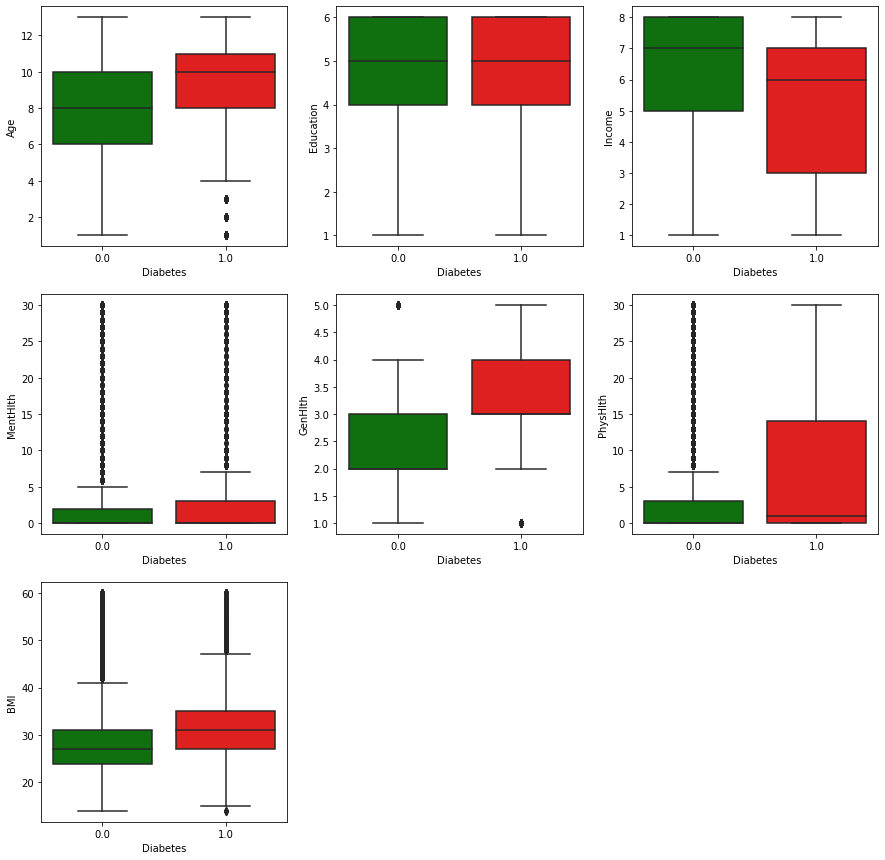

In [179]:
%matplotlib inline

features_boxplots = ['Age', 'Education', 'Income', 'MentHlth', 'GenHlth', 'PhysHlth', 'BMI']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

row_count = 0
col_count = 0

for feature in features_boxplots:
    sns.boxplot(ax=axes[row_count, col_count], data=df, x='Diabetes', y=feature, palette=['Green', 'Red'])
    col_count += 1
    if col_count > 2:
        row_count += 1
        col_count = 0

fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

##### Interpretation - Boxplots

In [ ]:
# Erklärung, warum bei manchen Boxplots der Median nicht eingezeichnet ist

### 2.6.2 Visualisierung der nominalskalierten Features in Abhängigkeit des Diabetesstatus
Zur Darstellung der Verteilung der **nominalskalierten** Variablen werden im Folgenden einige Säulendiagramme erstellt.

In [180]:
# Funktion zur Berechnung der bedingten Wahrscheinlichkeiten des Diabetes-Status unter bestimmten Bedingungen 
def create_diabetes_feature_tab(feature):
    # DataFrame erstellen, der die Anzahl aller Zugehörigen eines Features unter der Bedinungen des Diabetes-Status enthält 
    diabetes_feature_count = df.groupby(['Diabetes', feature]).size().reset_index(name = 'Count')
    # DataFrame erstellen, der die Anzahl aller Zugehörigen zum jeweiligen Diabetes-Typ enthält
    diabetes_count_total = diabetes_feature_count.groupby(['Diabetes']).sum().Count
    # gerade erstellte DataFrames zusammenfügen
    diabetes_feature_count_tab = diabetes_feature_count.set_index('Diabetes').join(diabetes_count_total,rsuffix='_Diabetes')
    # neue Spalte hinzufügen, die prozentualen Anteil von Personen einer Featureausprägung in Bezug auf jeweiligen Diabetestyp enthält
    diabetes_feature_count_tab['Percentage'] = diabetes_feature_count_tab['Count']/diabetes_feature_count_tab['Count_Diabetes']
    # Indizes des DataFrames zurücksetzen
    diabetes_feature_count_tab.reset_index(inplace = True)
    # Antworten leichter verständlich machen
    diabetes_feature_count_tab['Diabetes'].replace({0.0: 'Healthy', 1.0: 'Diabetes'}, inplace=True)
    diabetes_feature_count_tab[feature].replace({0.0: 'No', 1.0: 'Yes'}, inplace=True)
    return diabetes_feature_count_tab

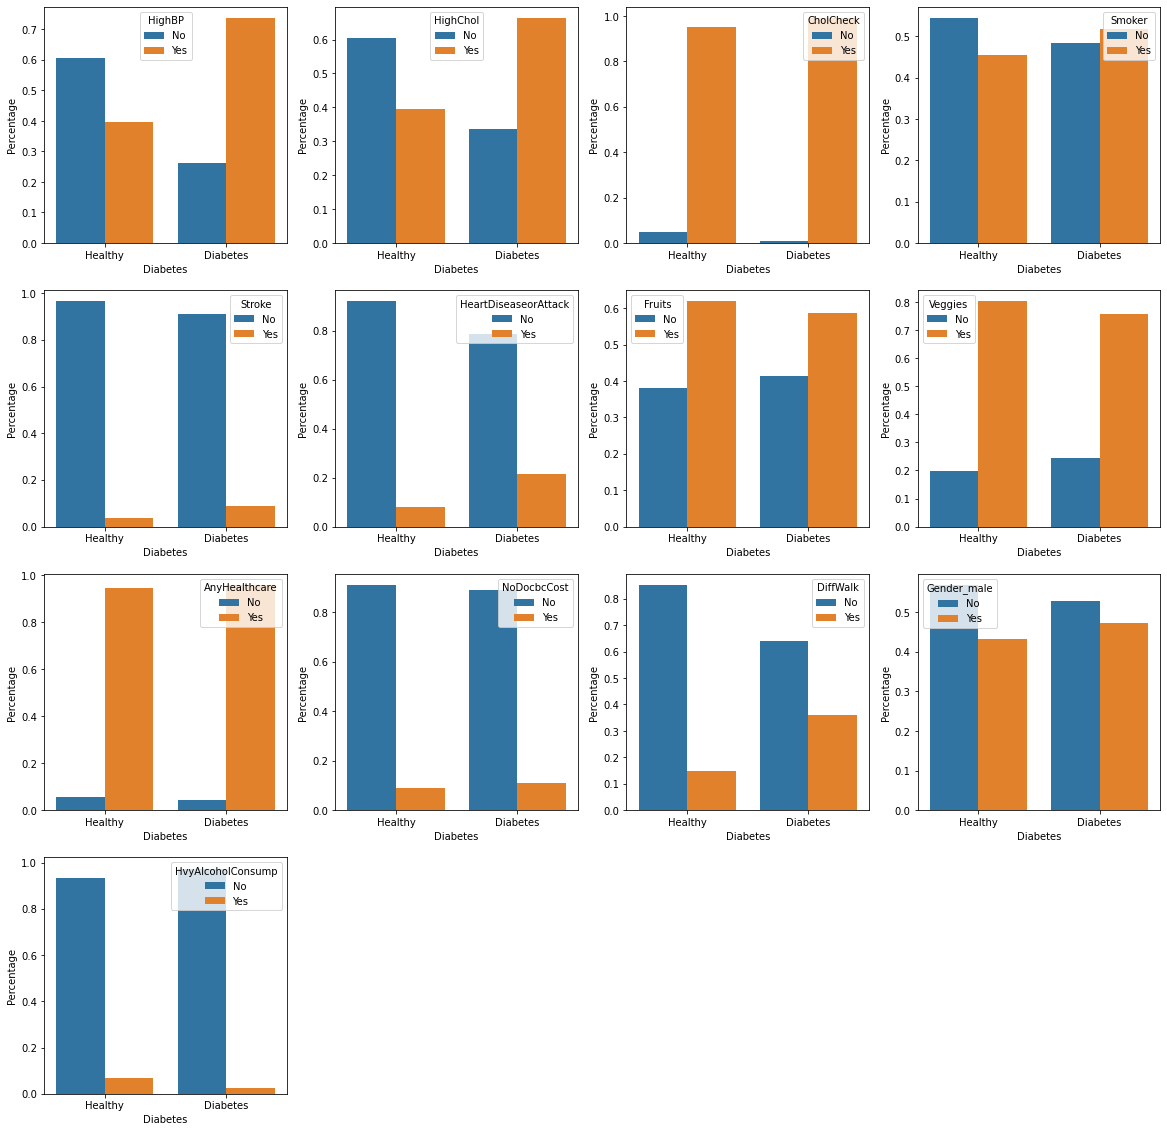

In [208]:
features_barplots = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke','HeartDiseaseorAttack', 'Fruits', 'Veggies', 
                     'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Gender_male', 'HvyAlcoholConsump']

fig, axes = plt.subplots(4, 4, figsize=(20,20))

row_count = 0
col_count = 0

for feature in features_barplots:
    diabetes_feature_count_tab = create_diabetes_feature_tab(feature)
    sns.barplot(x='Diabetes', y='Percentage', hue=feature, data=diabetes_feature_count_tab, ax=axes[row_count, col_count])
    col_count += 1
    if col_count > 3:
        row_count += 1
        col_count = 0
        
fig.delaxes(axes[3,1])
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,3])

### 2.6.3 Visualisierung der metrischen Features in Abhängigkeit des Diabetesstatus

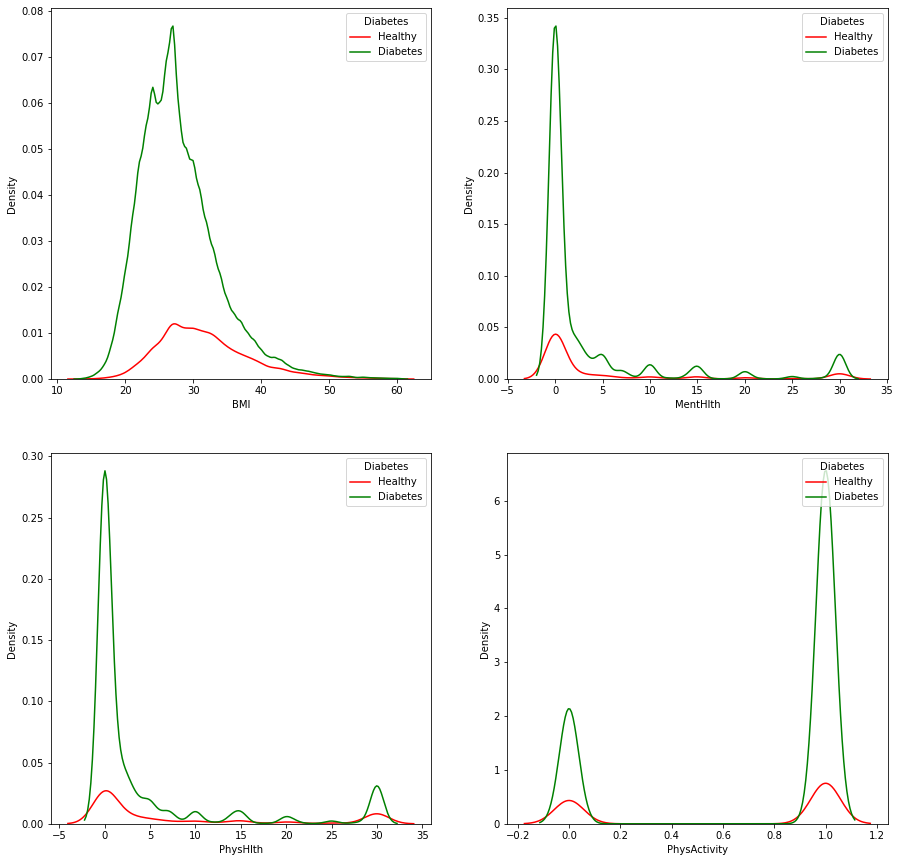

In [199]:
features_kdeplot = ['BMI', 'MentHlth', 'PhysHlth', 'PhysActivity']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

row_count = 0
col_count = 0

for feature in features_kdeplot:
    sns.kdeplot(ax=axes[row_count, col_count], data=df, x=feature, hue='Diabetes', legend=False, palette=['Green', 'Red'])
    axes[row_count,col_count].legend(title='Diabetes', loc='upper right', labels=['Healthy', 'Diabetes'])
    col_count += 1
    if col_count == 2:
        row_count += 1
        col_count = 0
      
plt.show()

### 2.6.4 Nähere Betrachtung einiger Features

#### 2.6.4.1 High Cholesterol vs. Cholesterol Check

In [ ]:
# sns.barplot(x='HighChol', hue='CholCheck', data=df)
# distplot
# Plot Age vs. Gender

## 2.7 statistische Zusammenhänge zwischen den Variablen

### 2.7.1 Zusammenhang zwischen numerischen Inputs und kategorischem Output

#### 2.7.1.1 Kendall'scher Rangkorrelationskoeffizient

C:\Users\Max\anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


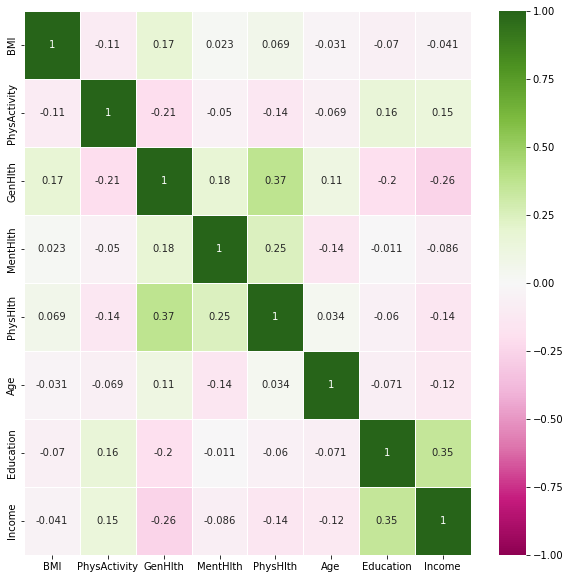

In [209]:
df_ordinal_or_more = df[['BMI', 'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']]

fig = plt.figure(figsize=(10,10))
sns.heatmap(df_ordinal_or_more.corr(method='kendall'), vmin=-1, vmax=1, cmap='PiYG', annot=True, linewidths=1)
plt.show()

#### 2.7.1.2 Analysis of Variance (ANOVA)

### 2.7.2 Zusammenhang zwischen kategorischen Inputs und kategorischem Output

In [ ]:
# Erklärung welche Methoden hierfür verwendet werden dürfen

In [ ]:
# kategorisch = kategorial?

#### 2.7.2.1 Chi-Quadrat-Test

In [ ]:
# Erklärung zum Chi-Quadrat-Test einfügen, kurz beschreiben warum Heatmap gewählt wurde
# Skalenniveaus überprüfen

In [210]:
categorical_features_list = ['Diabetes', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk',
                       'Gender_male', 'Age', 'Education', 'Income']

chisqmatrix = pd.DataFrame(columns=categorical_features_list, index=categorical_features_list)

for i in categorical_features_list:
    for j in categorical_features_list:
        if i != j:
            chi2_val, p_val = chi2(np.array(df[i]).reshape(-1,1), np.array(df[j]).reshape(-1,1))
            chisqmatrix.loc[i, j] = p_val
        else:
            chisqmatrix.loc[i, j] = 0.0

##### Visualisierung - Chi-Quadrat-Test

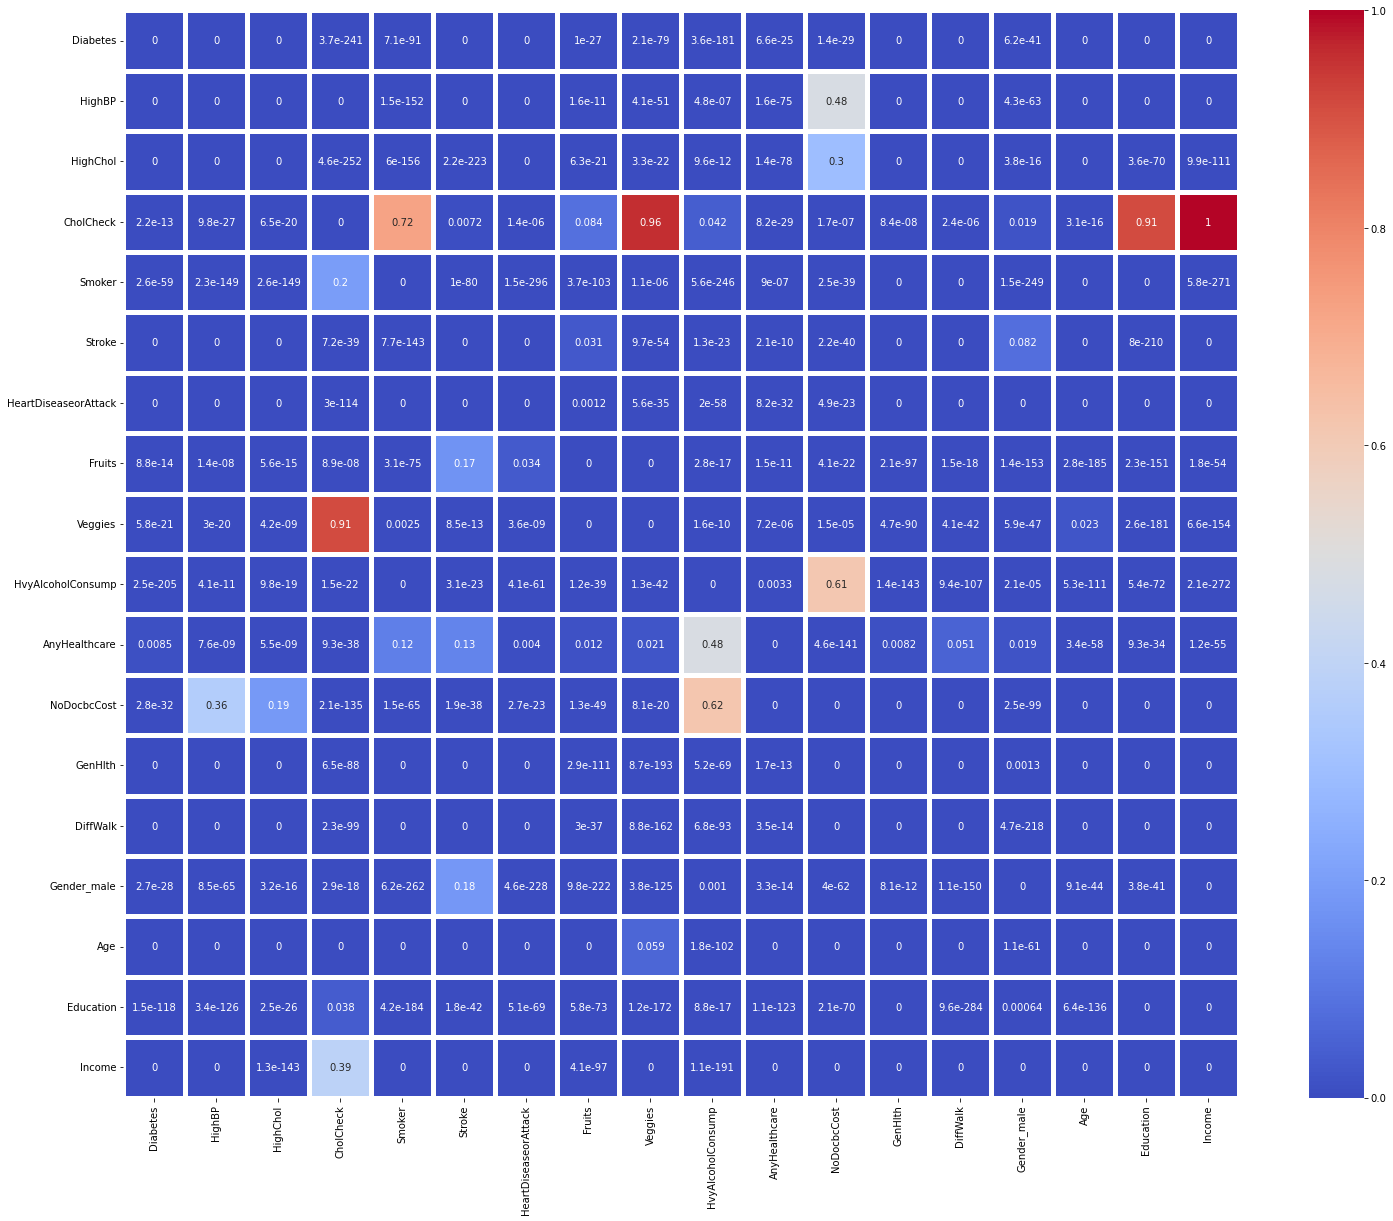

In [211]:
fig = plt.figure(figsize=(25,20))
sns.heatmap(chisqmatrix.astype(np.float64), annot=True, linewidths=5, vmin=0, vmax=1, cmap='coolwarm')
plt.show()

In [ ]:
# chi2(np.array(df['HighChol']).reshape(-1,1), np.array(df['CholCheck']).reshape(-1,1))

##### Interpretation - Chi-Quadrat-Test

In [ ]:
# viele niedrige Werte wegen großer Stichprobenanzahl (s. Datatab)

##### Quellen zum Code (Chi-Quadrat-Test) 
*https://medium.com/analytics-vidhya/constructing-heat-map-for-chi-square-test-of-independence-6d78aa2b140f*
*https://www.analyticsvidhya.com/blog/2021/06/decoding-the-chi-square-test%E2%80%8A-%E2%80%8Ause-along-with-implementation-and-visualization/*

##### weitere Quellen (Chi-Quadrat-Test)
*https://datatab.de/tutorial/chi-quadrat*

# 3. Data Preparation

In [ ]:
# evtl. Variante einfügen, in der BMI, PhysActivity, PhysHlth, MentHlth nochmals gruppiert sind --> Sensititvitätsanalyse
# evtl. auch binäre Klassifikation testen (Nein = 0.0, Ja = 1.0+2.0)

## 3.1 Data Cleaning

### 3.1.1 Duplikate entfernen

Im Bereich des Machine Learnings können **doppelte Feature Vektoren** aus verschiedenen Gründen **problematisch** werden. Fällt zum Beispiel eine Zeile nach dem Split in den Trainingsdatensatz und die andere, gleiche Zeile in den Testdatensatz, so hat das Modell diese Daten bereits gesehen. Hierdurch wird das anschließende Ergebnis verzerrt. (*https://deepchecks.com/what-is-data-cleaning/*) Hierbei könnten doppelte Zeilen im Datensatz zu **Overfitting** führen, wenn das Modell mehrmals mit den gleichen Daten trainiert wird. Um dies zu verhindern werden die Duplikate aus dem "Diabetes Health Indicators" Datensatz ausfindig gemacht und **entfernt**.

In [ ]:
# Anzahl der Zeilen im unbereinigten Datensatz
print(f'Der unbereinigte Datensatz umfasst {df.shape[0]} Feature Vektoren.')

In [ ]:
duplicates = df[df.duplicated()]
print(f'Davon sind {len(duplicates)} Zeilen doppelt.')

In [ ]:
# Ausgabe der doppelten Zeilen
duplicates

In [6]:
# doppelte Zeilen werden entfernt
df.drop_duplicates(inplace = True)

In [ ]:
# Anzahl der Zeilen im bereinigten Datensatz
print(f'Der bereinigte Datensatz beinhaltet noch die Daten von {df.shape[0]} Patienten.')

In [ ]:
df_dup_removed_diab_perc_list = calc_prozentual_target(df)

print(f'Der bereinigte Datensatz enthält {diabetes_perc_df[0]} % gesunde Patienten und {diabetes_perc_df[1] }% Patienten mit Diabetes.')

##### Zusammenfassung - Doppelte Zeilen entfernen

Obwohl die Unbalanciertheit des Datensatzes durch das Entfernen der doppelten Zeilen etwas vergrößert wird, sprechen unter anderem die oben genanneten Gründe dafür, sie zur weiteren Bearbeitung aus dem Datensatz zu entfernen. 

### 3.1.2 Unplausible Werte

Aus dem unteren Boxplot in Kap. 2.5.1 und der Informationstabelle, die in Kap. 2.3 mithilfe von df.describe() erstellt wurde, lässt sich ein Maximalwert des BMI von 98 kg/m² erkennen. Da man laut der deutschen Adipositas Gesellschaft bereits ab einem BMI über 40kg/m² unter Adipositas Grad III fällt, sind Werte ab einem BMI über 60kg/m² als kritisch einzustufen. (*https://adipositas-gesellschaft.de/bmi/*) Gleiches gilt für den Minimalwert des BMI, der im Datensatz bei 12 kg/m² liegt. Generell gilt ein BMI von unter 14,5 kg/m² als lebensgefährlich. Aus diesem Grund werden Patienten mit einem BMI unter 14 kg/m² aus dem Datensatz entfernt.

In [8]:
lower_crit_value_bmi = 14
upper_crit_value_bmi = 60

df_low_bmi = df.loc[df['BMI'] < lower_crit_value_bmi]
df_high_bmi = df.loc[df['BMI'] > upper_crit_value_bmi]

print(f'Der Datensatz enthält {df_low_bmi.shape[0]} Patienten mit einem kritischen BMI von unter {lower_crit_value_bmi} kg/m² und {df_high_bmi.shape[0]} Patienten mit einem kritischen BMI von über {upper_crit_value_bmi} kg/m².')

Der Datensatz enthält 27 Patienten mit einem kritischen BMI von unter 14 kg/m² und 805 Patienten mit einem kritischen BMI von über 60 kg/m².


Die Patienten mit einem kritisch hohen BMI verbleiben vorerst im Datensatz, da solch hohe BMI-Werte in der Realitiät tatsächlich vorkommen können. Nachdem allerdings ein BMI von unter 14,5 kg/m² als lebensgefährlich gilt, werden Patienten mit einem BMI von unter 14 kg/m² aus dem Datensatz entfernt.

##### Entfernen der Featurevektoren mit kritischem BMI (niedrig)

In [9]:
df.drop(df_low_bmi.index, axis=0, inplace=True)

In [10]:
df.drop(df_high_bmi.index, axis=0, inplace=True)

In [ ]:
# Sensitivitätsanalyse mit und ohne Patienten mit hohem BMI

## 3.2 Vorbereitung des Modellings

Für anschließende Vorgänge in der Vorbereitung des Modellings und im Modelling selbst kann es nützlich sein, den Datensatz in Features (x-Werte) und Target (y-Wert) aufzuteilen. Da im weiteren Verlauf eine erneute Trennung des Datensatzes in x- und y-Werte erforderlich sein kann, z.B. nach der Skalierung, werden im Folgenden zwei Funktionen hierfür implementiert.

In [11]:
def get_x_values(df):
    x_values = df.drop(['Diabetes'], axis='columns')
    return x_values

def get_y_value(df):
    y_value = df['Diabetes']
    return y_value

x_values = get_x_values(df)
y_value = get_y_value(df)

### 3.2.1 Umgang mit kategorischen Daten

Da ein **Machine Learning Algorithmus** immer besser mit **numerischen Werten** arbeiten kann, als mit kategorischen Variablen. Aus diesem Grund müssen kategorische Daten häufig speziell für das Modelling vorbereitet werden, indem die kategorischen Werte in numerische Werte **umgewandelt** werden. Dies gilt vor allem für die Features, für manche Machine Learning-Algorithmen, vor allem im Bereich des Deep Learnings, aber auch für die Targetvariable. Allerdings muss die Targetvariable nur im Fall der Multiclass-Klassifikation umgewandelt werden. 

Generell gelten für das OneHot Encoding von kategorischen Daten noch einige Zusätze. Variablen, die als Ausprägungen nur die Werte **0 und 1** annehmen können, müssen **nicht umgewandelt** werden. Hier reicht eine genaue Bezeichnung für die Variable, um den Wert darstellen zu können. Ein Beispiel hier wäre, dass man beim Geschlecht nicht zwei Variablen (eine für männlich und eine für weiblich braucht), sondern bspw. männlich ausreichend ist. Beim vorliegenden Datensatz ist nämlich klar, dass es sich um einen weiblichen Patienten handelt, falls der Wert für 'Male' 0 ist, da es keine Ausprägung für divers gibt.

Zudem muss beachtet werden, dass Variablen, deren Ausprägungen eine vorgegebene Rangordnung (mit gleichen Min-Max-Abständen) haben, nicht unbedingt umgewandelt werden müssen. Beim vorliegenden Datensatz wird zum Beispiel die Variable 'Age' nicht umgewandelt, da jede Altersklasse ungefähr gleich groß ist (5-7 Jahre) und somit eine feste Rangordnung zwischen den einzelnen Klassen besteht, die für die Vorhersage von Diabetes eine wichtige Rolle spielt. Ähnliches gilt in diesem Fall für das Feature 'Income', obwohl dort die Klassen teilweise unterschiedliche Spannen aufweisen.

Anders verhält es sich mit den Variablen 'GenHlth', 'Education'. Hier liegen keine fest definierten Abstände vor, weshalb auch keine klare Rangordnung gebildet werden kann, mit der der Algorithmus rechnen kann. Diese werden deshalb umgewandelt. In einem späteren Kapitel wird hierzu auch eine Sensitivitätsanalyse durchgeführt.

In [90]:
features_to_encode = ["GenHlth","Education", "Income"]
df_encoded = pd.get_dummies(df, columns = features_to_encode, drop_first=True)

In [165]:
pd.set_option('display.max_columns', None)
df_encoded.head()

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,GenHlth_2.0,GenHlth_3.0,GenHlth_4.0,GenHlth_5.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Education_6.0,Income_2.0,Income_3.0,Income_4.0,Income_5.0,Income_6.0,Income_7.0,Income_8.0
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,18.0,15.0,1.0,0.0,9.0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,30.0,30.0,1.0,0.0,9.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,11.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
df_encoded.shape

##### Quellen (Umgang mit kategorischen Daten)
*https://analyticsindiamag.com/when-to-use-one-hot-encoding-in-deep-learning/#:~:text=One%20hot%20encoding%20can%20be,classification%20accuracy%20of%20a%20model.*

*https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/*

*https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/*

*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.204. Apress.*

### 3.2.3 Oversampling/ Undersampling

#### 3.2.3.1 SMOTE Oversampling

In [12]:
oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x_values, y_value)

In [11]:
y_smote.value_counts()

0.0    189414
1.0    189414
Name: Diabetes, dtype: int64

In [ ]:
# Sensitivitätsanalyse --> Oversampling+kFold vs. StratifiedKFold

In [ ]:
# compute_class_weight --> parameter 'class_weight'

*https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/*

*https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/*

#### 3.2.3.2 Kombination aus Over- und Undersampling

In [13]:
over_step1 = SMOTE(sampling_strategy=0.5)
x_over_step1, y_over_step1 = over_step1.fit_resample(x_values, y_value)

under_step2 = RandomUnderSampler()
x_ou_combi, y_ou_combi = under_step2.fit_resample(x_over_step1, y_over_step1)

##### Quellen zum Code

*https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/*

### 3.2.2 Feature Scaling

#### 3.2.2.1 Einführung in das Thema Feature Scaling

Wenn ein Modell mit unskalierten Daten trainiert wird, bei dem einige Features einen (deutlich) größeren Wertebereich haben, als andere, kann es beim Training des Modells dazu führen, dass diese Features einen größeren Einfluss auf den Ausgang des Modells haben. Obwohl ein paar Machine-Learning-Algorithmen, wie z.B. baumbasierte Methoden, auch ohne Feature Scaling auskommen, ist es üblich, diese vor dem Modelling zu skalieren. Dies gilt besonders, wenn man viele verschiedene Machine Learning Algorithmen testen und vergleichen will. (*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.239. Apress.*)

Im Folgenden wird eine Funktion scale_df() implementiert, die einen DataFrame und eine Scaling-Methode entgegen nimmt, und den skalierten Datensatz zurückgibt. Diese wird im Modelling an geeigneter Stelle eingesetzt, um die **Daten zu skalieren**. 

In [ ]:
# es gibt verschiedene Methoden zum Skalieren der Features

In [48]:
def scale_df(df, scaler_method):
    scaler = scaler_method
    scaled_data = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled_data, columns = df.columns)
    return df_scaled

#### 3.2.2.2 Vorbereitung - Feature Scaling

Genauso wie es wichtig ist das Modell mit unbekannten Testdaten zu testen, ist es auch wichtig, das Scaling innerhalb des Splits durchzuführen. *(Computing cross-validated metrics, 3.1.1 https://scikit-learn.org/stable/modules/cross_validation.html)* Anderenfalls könnte das Skalieren des gesamten Datensatzes dazu führen, dass Informationen aus dem Datensatz noch vor dem Test in das Modell geraten und das anschließende Ergebnis verzerren.

Im Folgenden wird innerhalb eines ersten Stratified KFold-Splits analysiert, ob verschiedene statistische Werte beim Skalieren der Daten in den verschiedenen Folds voneinander abweichen. Falls das nicht der Fall ist, kann das Scaling trotzdem auf den gesamten Datensatz angewendet werden. Darüber hinaus kann es hilfreich sein, um einen Eindruck über die Güte des gewählten Splits zu erhalten.

In [13]:
def create_df_scaling_cv_feature(x_values, y_value, scaler):
    features = list(x_values.columns)
    df_column_names = ['Feature', 'Split', 'Train_Minima', 'Test_Minima', 'Train_Maxima', 'Test_Maxima']
    df_scaled_values = pd.DataFrame(columns=df_column_names)
    split_counter = 1
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(x_values, y_value):
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        scaler = scaler
        scaled_train = scaler.fit_transform(X_train)
        scaled_test = scaler.transform(X_test)
        df_scaled_train = pd.DataFrame(scaled_train, columns=features)
        df_scaled_test = pd.DataFrame(scaled_test, columns=features)
        for idx, feature in enumerate(features):
            row_counter = (split_counter-1)*len(features) + idx
            df_scaled_values.at[row_counter, 'Split'] = split_counter
            df_scaled_values.at[row_counter, 'Feature'] = feature
            df_scaled_values.at[row_counter, 'Train_Minima'] = df_scaled_train.iloc[:, idx].min()
            df_scaled_values.at[row_counter, 'Train_Maxima'] = df_scaled_train.iloc[:, idx].max()
            df_scaled_values.at[row_counter, 'Test_Minima'] = df_scaled_test.iloc[:, idx].min()
            df_scaled_values.at[row_counter, 'Test_Maxima'] = df_scaled_test.iloc[:, idx].max()
        split_counter += 1 
    df_scaled_values.sort_values(by=['Feature', 'Split'], inplace=True)
    return df_scaled_values

##### Vergleich der Minima und Maxima bei Scaling mit dem MinMaxScaler innerhalb eines StratifiedKFold-Splits

In [14]:
pd.set_option('display.max_rows', None)
df_minmax_scaler_cv = create_df_scaling_cv_feature(x_values, y_value, MinMaxScaler())
df_minmax_scaler_cv

,Feature,Split,Train_Minima,Test_Minima,Train_Maxima,Test_Maxima
18,Age,1,0.0,0.0,1.0,1.0
39,Age,2,0.0,0.0,1.0,1.0
60,Age,3,0.0,0.0,1.0,1.0
81,Age,4,0.0,0.0,1.0,1.0
102,Age,5,0.0,0.0,1.0,1.0
123,Age,6,0.0,0.0,1.0,1.0
144,Age,7,0.0,0.0,1.0,1.0
165,Age,8,0.0,0.0,1.0,1.0
186,Age,9,0.0,0.0,1.0,1.0
207,Age,10,0.0,0.0,1.0,1.0


In [ ]:
# Ungenauigkeiten zwischen den Splits nur bei BMI --> evtl. Ausreißer überprüfen

##### Vergleich der Minima und Maxima bei Scaling mit dem StandardScaler innerhalb eines StratifiedKFold-Splits

In [15]:
pd.set_option('display.max_rows', None)
df_minmax_scaler_cv = create_df_scaling_cv_feature(x_values, y_value, StandardScaler())
df_minmax_scaler_cv

,Feature,Split,Train_Minima,Test_Minima,Train_Maxima,Test_Maxima
18,Age,1,-2.292704,-2.292704,1.587046,1.587046
39,Age,2,-2.291639,-2.291639,1.586301,1.586301
60,Age,3,-2.292292,-2.292292,1.586113,1.586113
81,Age,4,-2.290133,-2.290133,1.58774,1.58774
102,Age,5,-2.29282,-2.29282,1.587647,1.587647
123,Age,6,-2.293098,-2.293098,1.586893,1.586893
144,Age,7,-2.292434,-2.292434,1.588285,1.588285
165,Age,8,-2.292606,-2.292606,1.586213,1.586213
186,Age,9,-2.292234,-2.292234,1.586978,1.586978
207,Age,10,-2.288323,-2.288323,1.585326,1.585326


#### 3.2.2.3 Interpretation (Vorbereitung - Feature Scaling)

Es ist zu erkennen, dass weder die Minimal-, noch die Maximalwerte der skalierten Daten (sowohl mit dem StandardScaler(), als auch mit dem MinMaxScaler()) bei einem StratifiedKFold-Split mit 10 Folds deutlich voneinander abweichen. Hierdurch ist es möglich, die Daten bereits vor dem Modelling mithilfe des ganzen Datensatzes durchzuführen, ohne dass es zu Verzerrungen des Modells kommt. Ein Grund hierfür könnte beispielsweise der relativ große Umfang des Datensatzes sein. Darüber hinaus kann dies ein erstes Indiz dafür sein, dass der Split (StratifiedKFold mit 10 Folds) an dieser Stelle richtig gewählt wurde.

#### 3.2.2.4 Feature Scaling - Standartisieren mit dem StandardScaler

In [ ]:
# Erklärung StandardScaler

In [31]:
df_scaled_ss = scale_df(df, StandardScaler())
df_scaled_ss

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,Education,Income
0,-0.456463,1.096028,1.123943,0.205488,1.862121,1.070723,-0.216536,-0.339353,-1.659715,-1.259021,...,0.238628,-0.319807,2.255396,1.880735,1.143245,2.099021,-0.884857,0.293960,-0.987576,-1.382424
1,-0.456463,-0.912386,-0.889725,-4.866458,-0.571218,1.070723,-0.216536,-0.339353,0.602513,-1.259021,...,-4.190626,3.126886,0.375776,-0.454232,-0.516457,-0.476412,-0.884857,-0.352487,1.027044,-2.338694
2,-0.456463,1.096028,1.123943,0.205488,-0.084550,-0.933948,-0.216536,-0.339353,-1.659715,0.794268,...,0.238628,3.126886,2.255396,3.437379,2.802946,2.099021,-0.884857,0.293960,-0.987576,1.008251
3,-0.456463,1.096028,-0.889725,0.205488,-0.246773,-0.933948,-0.216536,-0.339353,0.602513,0.794268,...,0.238628,-0.319807,-0.564034,-0.454232,-0.516457,-0.476412,-0.884857,0.940407,-1.994886,0.051981
4,-0.456463,1.096028,1.123943,0.205488,-0.733441,-0.933948,-0.216536,-0.339353,0.602513,0.794268,...,0.238628,-0.319807,-0.564034,-0.065071,-0.516457,-0.476412,-0.884857,0.940407,0.019734,-0.904289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228875,-0.456463,1.096028,1.123943,0.205488,2.673235,-0.933948,-0.216536,-0.339353,-1.659715,0.794268,...,0.238628,-0.319807,0.375776,-0.454232,0.036777,-0.476412,1.130127,-0.998934,1.027044,0.530116
228876,2.190758,1.096028,1.123943,0.205488,-1.706777,-0.933948,-0.216536,-0.339353,-1.659715,-1.259021,...,0.238628,-0.319807,1.315586,-0.454232,-0.516457,2.099021,-0.884857,0.940407,-3.002195,-0.904289
228877,-0.456463,-0.912386,-0.889725,0.205488,-0.084550,-0.933948,-0.216536,-0.339353,0.602513,0.794268,...,0.238628,-0.319807,-1.503844,-0.454232,-0.516457,-0.476412,-0.884857,-1.968604,0.019734,-1.860559
228878,-0.456463,1.096028,-0.889725,0.205488,-0.895663,-0.933948,-0.216536,-0.339353,-1.659715,0.794268,...,0.238628,-0.319807,0.375776,-0.454232,-0.516457,-0.476412,1.130127,-0.352487,0.019734,-2.338694


##### x- und y-Werte (StandardScaler)

In [15]:
x_values_ss = scale_x_values(x_values, StandardScaler())

#### 3.2.2.5 Feature Scaling - Normalisieren mit dem MinMaxScaler

In [ ]:
# Erklärung MinMaxScaler

##### x- und y-Werte (MinMaxScaler)

In [21]:
x_values_mm = scale_x_values(x_values, MinMaxScaler())

## 3.3 Feature Selection

Ein weiterer wichtiger Schritt, der bereits zu Beginn des Modellings eine Rolle spielen kann ist die Feature Selection. Hierbei versucht man die Features ausfindig zu machen, die den größten Einfluss auf die vorhergesagte Klasse der Targetvariable haben. Dies ist nötig, da eine große Anzahl von Features dazu führen kann, dass das Modell komplexer und schwerer zu interpretieren wird. (*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.242. Apress.*) Feature Selection wird im Allgemeinen angewendet, um Overfitting zu vermeiden, die Accuracy zu erhöhen, und die Trainingsdauer zu minimieren. (*https://machinelearningmastery.com/feature-selection-machine-learning-python/*) Zur Berechung der Feature Importance stehen einem verschiedene Methoden zur Verfügung. Im Allgemeinen werden zur tatsächlichen Auswahl geeigneter Features mehrere dieser Möglichkeiten durchgeführt und anschließend das Gesamtergebnis interpretiert. Ähnlich wie beim Scaling der Features bietet es sich an, die Feature Selection vorerst im Rahmen eines Splits durchzuführen. Auch dieser Schritt zählt zur Vorbereitung des Modellings und müsste eigentlich ein Unterpunkt von Kapitel 3.2 sein, ist aber so umfangreich, dass er hier ein eigenes Teilkapitel bekommt.

### 3.3.1 Optimale Anzahl an Features

#### 3.3.1.1 Recursive Feature Elimination with Cross Validation (f1)

In [ ]:
rfc1 = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv1 = RFECV(estimator=rfc1, cv=cv, scoring='f1', min_features_to_select=1, verbose=1)
rfecv1.fit(x_values, y_value)

print("Optimal number of features : %d" % rfecv1.n_features_)

##### Visualisierung (3.3.1.1)

In [ ]:
plt.figure()
plt.xticks(np.arange(0, 22, step=2))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1 score)")
plt.plot(range(1, len(rfecv1.grid_scores_) + 1), rfecv1.grid_scores_)
plt.show()

##### 3.3.1.2 Encoded Datensatz

In [ ]:
rfc2 = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv2 = RFECV(estimator=rfc2, cv=cv, scoring='f1', min_features_to_select=1, verbose=1)
rfecv2.fit(x_values_encoded_mm, y_value)

print("Optimal number of features : %d" % rfecv1.n_features_)

In [ ]:
plt.figure()
plt.xticks(np.arange(0, 22, step=2))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1 score)")
plt.plot(range(1, len(rfecv1.grid_scores_) + 1), rfecv2.grid_scores_)
plt.show()

##### Quellen zum Code (Optimale Anzahl an Features)
*https://machinelearningmastery.com/rfe-feature-selection-in-python/*

*https://www.kdnuggets.com/2020/10/feature-ranking-recursive-feature-elimination-scikit-learn.html*

*https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py*

### 3.3.2 Univariate Selection

*https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/*

#### 3.3.2.1 Vorbereitung - Univariate Selection

In [77]:
def univariate_fs_scaling_cv(x_values, y_value, scaler, n_splits, score_func, k):
    print(f'Univariate Feature Selection mit Score-Func {str(score_func)} und Scaler {str(scaler)}')
    features = list(x_values.columns)
    scaler = scaler
    x_values_scaled = scaler.fit_transform(x_values)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    split_counter = 1
    ufs_scores = []
    ufs_p_values = []
    for train_index, test_index in skf.split(x_values_scaled, y_value):
        selected_features_list = []
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        fs = SelectKBest(score_func=score_func, k=k)
        fs.fit(X_train, y_train)
        X_train_fs = fs.transform(X_train)
        X_test_fs = fs.transform(X_test)
        selected_features_bool = fs.get_support()
        features = list(x_values.columns)
        for feature, selected_feature_bool in zip(features, selected_features_bool):
            if selected_feature_bool == True:
                selected_features_list.append(feature)
        print(f'Ausgewählte Features in Split {split_counter}: {selected_features_list}')
        split_counter += 1
        ufs_scores.append(fs.scores_)
        ufs_p_values.append(fs.pvalues_)
    return ufs_scores, ufs_p_values

def ufs_scaling_cv_plot_score(x_values, y_value, scaler, n_splits, score_func):
    print(f'Univariate Feature Selection mit Score-Func {str(score_func)} und Scaler {str(scaler)}')
    features = list(x_values.columns)
    scaler = scaler
    x_values_scaled = scaler.fit_transform(x_values)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    split_counter = 1
    for train_index, test_index in skf.split(x_values_scaled, y_value):
        selected_features_list = []
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        fs = SelectKBest(score_func=score_func, k='all')
        fs.fit(X_train, y_train)
        features = list(x_values.columns)
        plt.figure(figsize=(15,10))
        scores_normalized = fs.scores_ / np.amax(fs.scores_)
        plt.barh(features, scores_normalized, label='Score in Split CV ' + str(split_counter))
        plt.yticks(np.arange(0, len(features), step=1), features)
        plt.legend(loc='upper right')
        plt.show()
        split_counter += 1

#### 3.3.2.2 Auswahl der wichtigsten kategorischen Features

In [176]:
df_categorical_features = df.drop(['BMI', 'MentHlth', 'PhysHlth', 'PhysActivity', 'Diabetes'], axis = 'columns')

##### Visualisierung der Scores aus SelectKBest mit StandardScaler (Chi-Quadrat-Test) 

Univariate Feature Selection mit Score-Func <function chi2 at 0x000001A23B688A60> und Scaler StandardScaler()


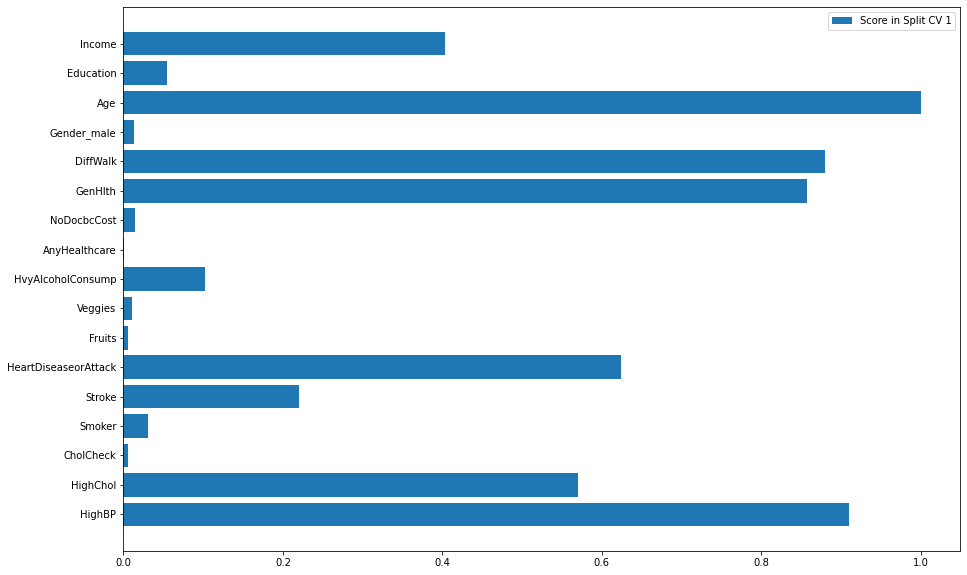

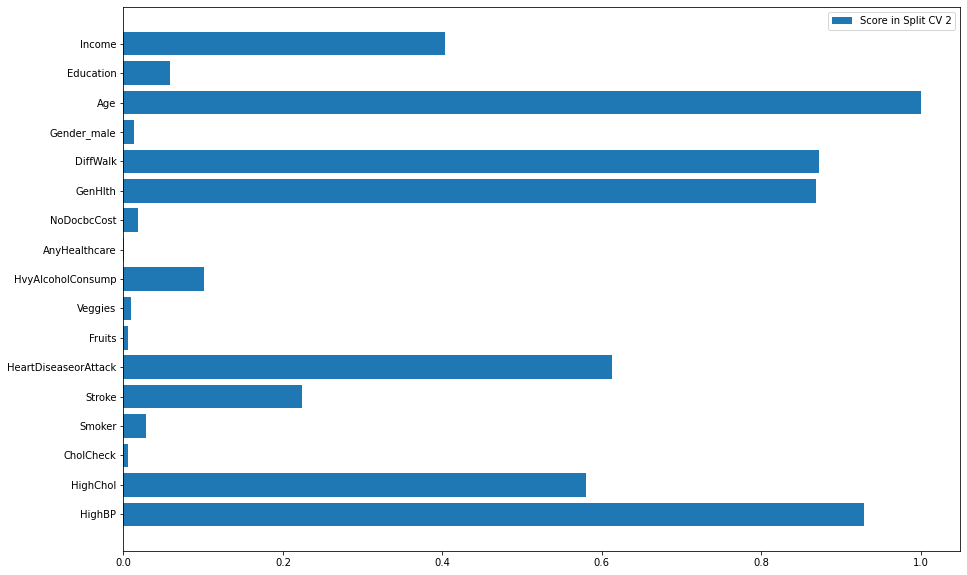

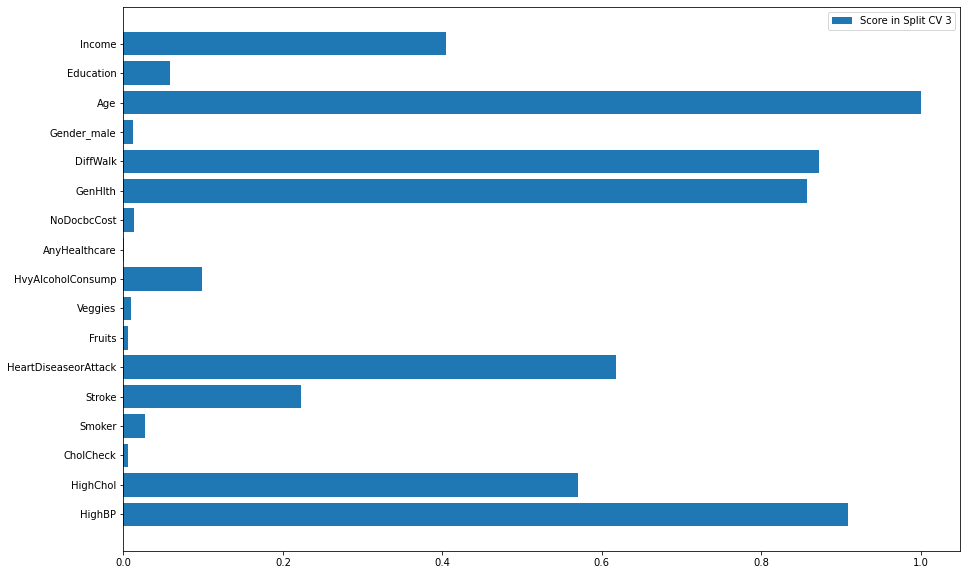

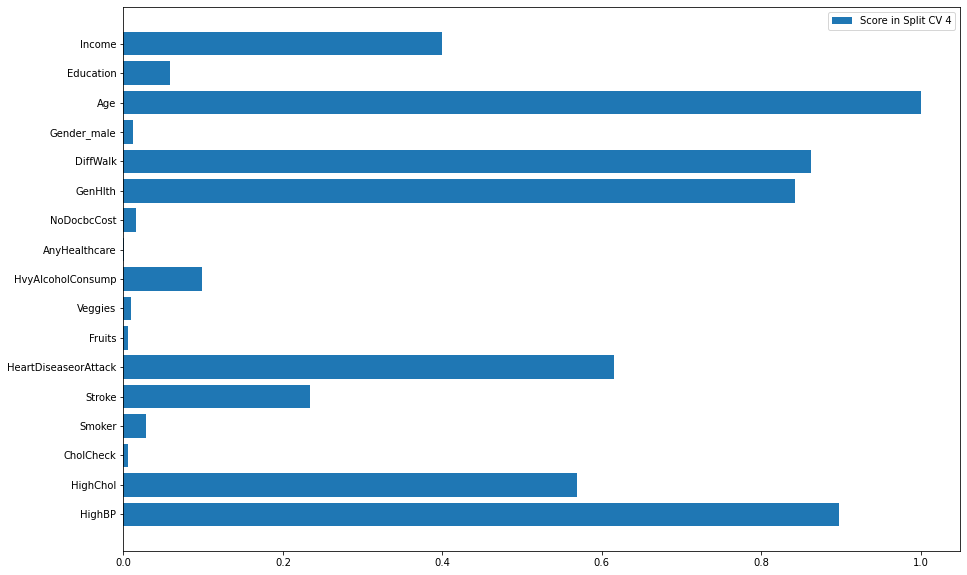

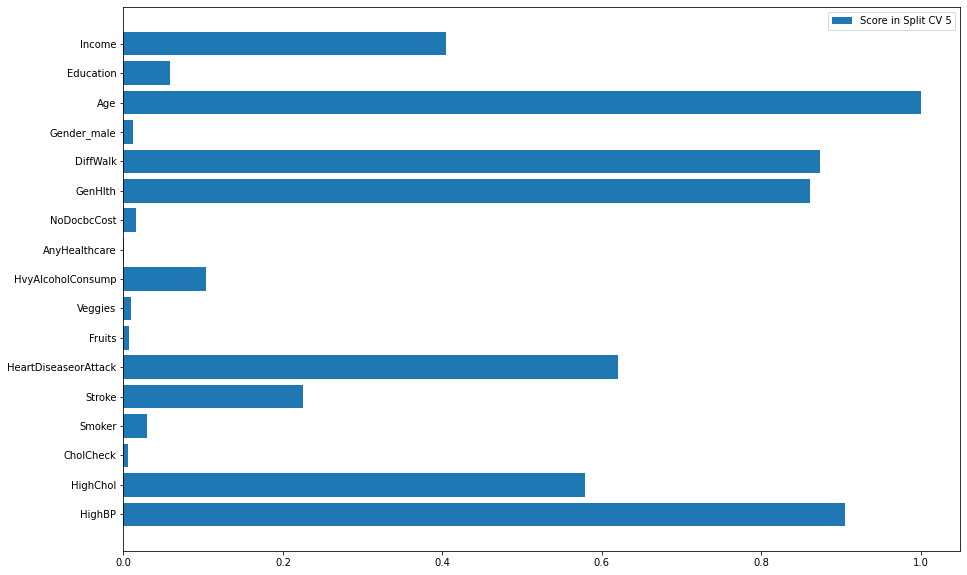

In [79]:
ufs_scaling_cv_plot_score(df_categorical_features, y_value, StandardScaler(), 5, chi2)

##### Visualisierung der Scores aus SelectKBest mit MinMaxScaler (Chi-Quadrat-Test) 

Univariate Feature Selection mit Score-Func <function chi2 at 0x000001A23B688A60> und Scaler MinMaxScaler()


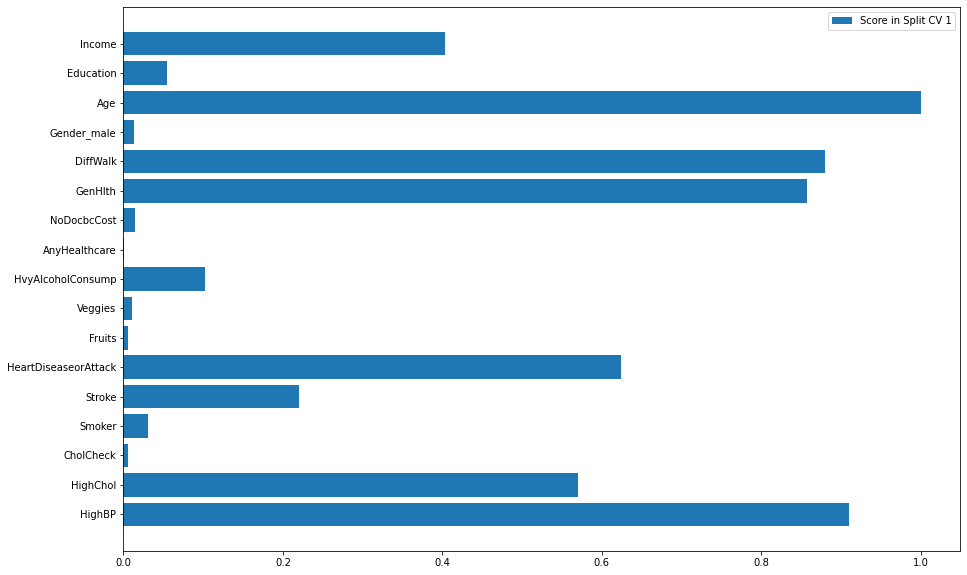

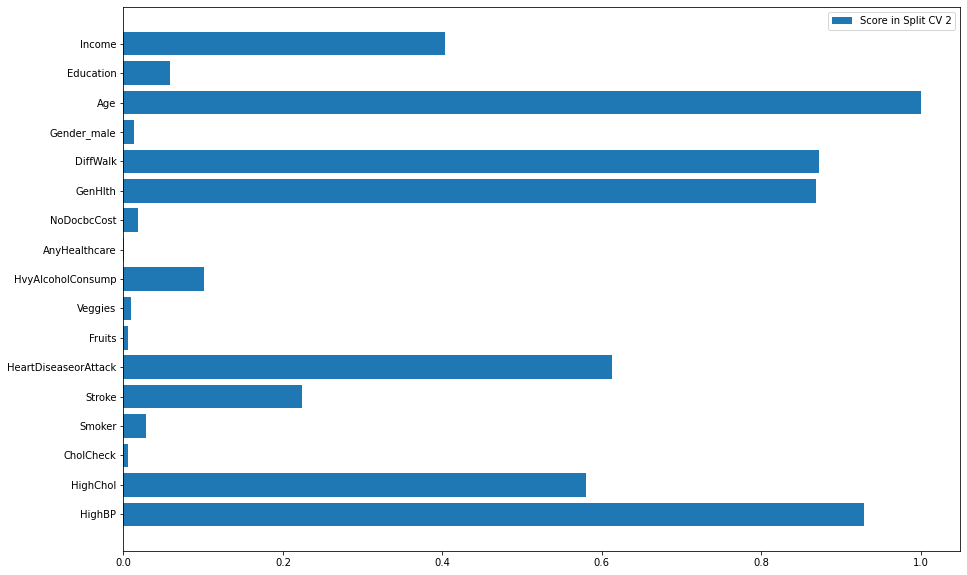

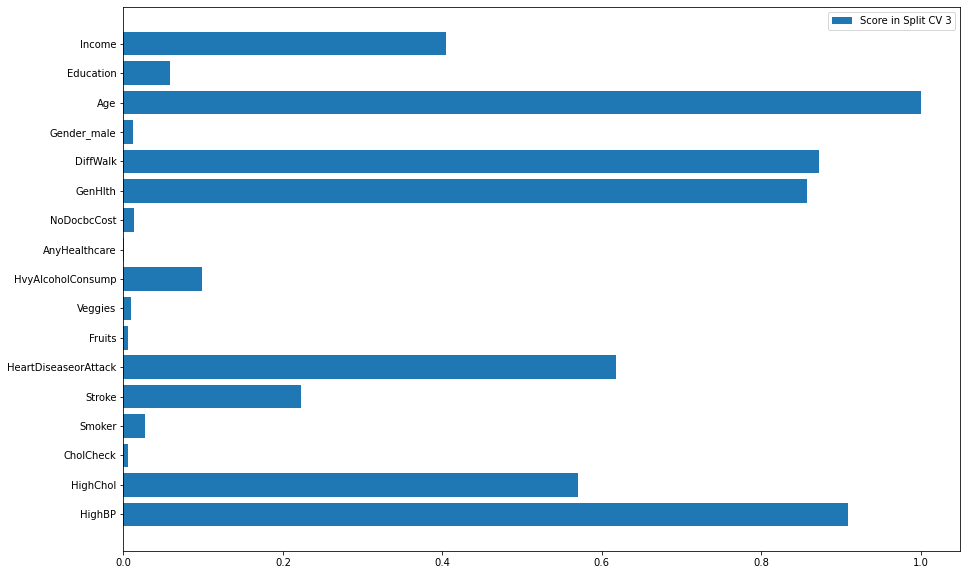

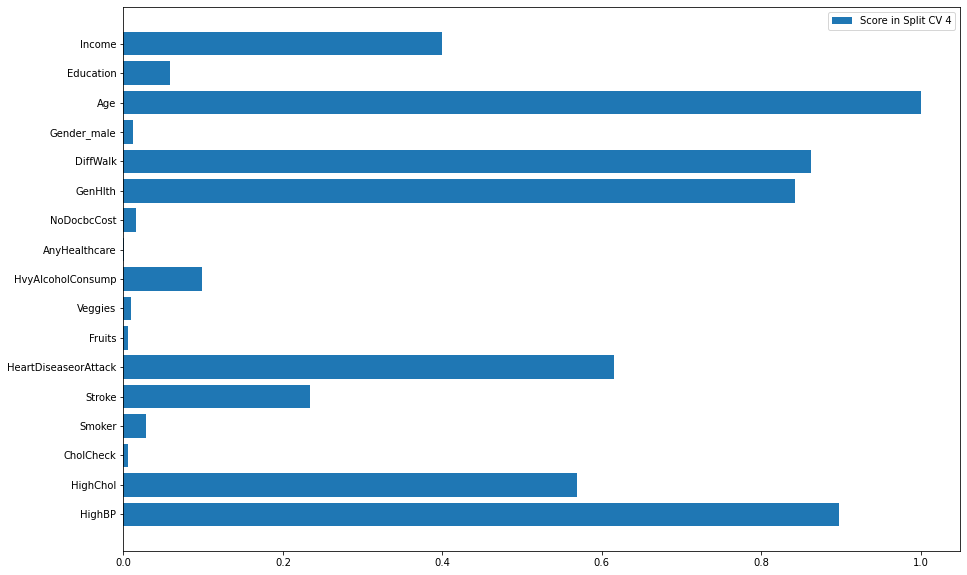

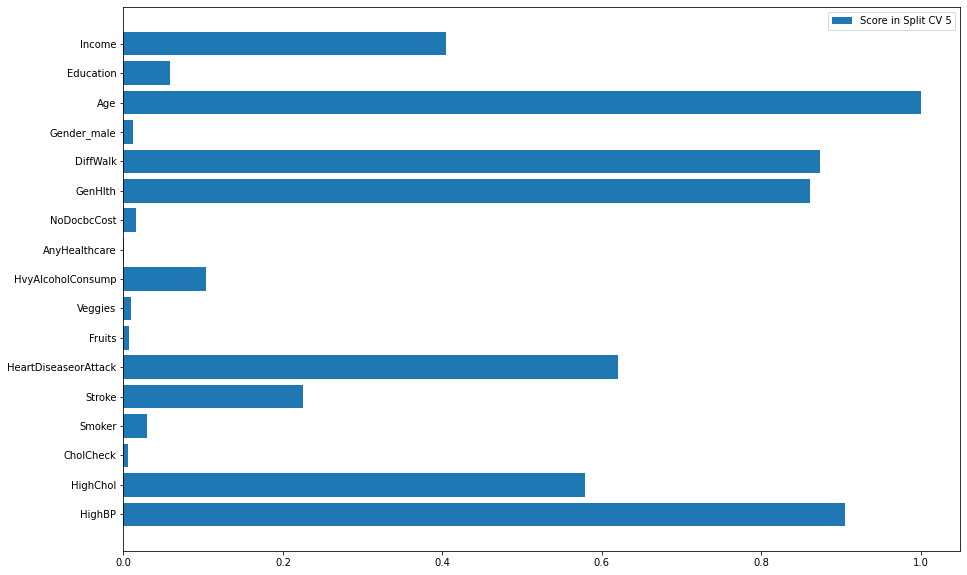

In [80]:
ufs_scaling_cv_plot_score(df_categorical_features, y_value, MinMaxScaler(), 5, chi2)

##### Visualisierung der Scores aus SelectKBest mit StandardScaler (Mutual Info Classification)

Univariate Feature Selection mit Score-Func <function mutual_info_classif at 0x000001A23BA01AF0> und Scaler StandardScaler()


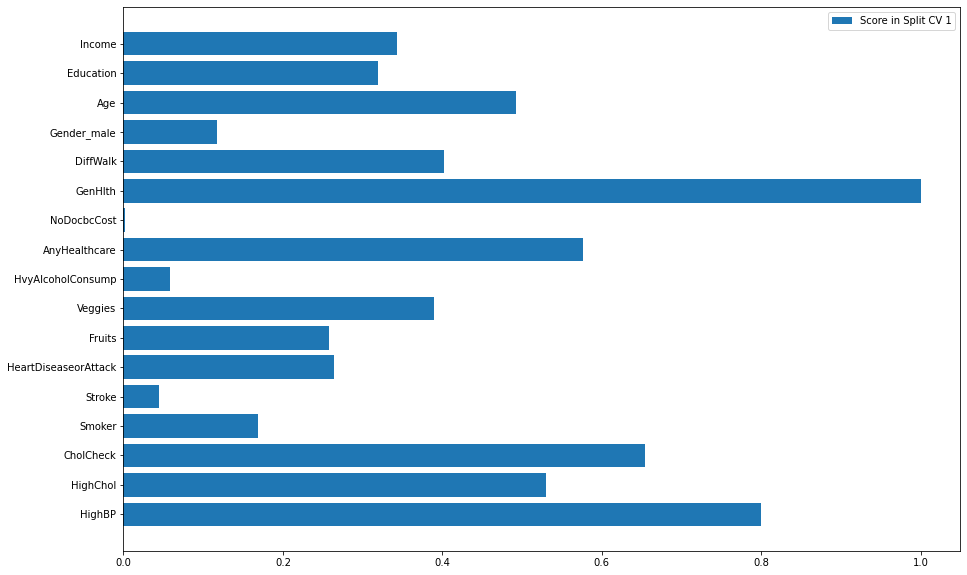

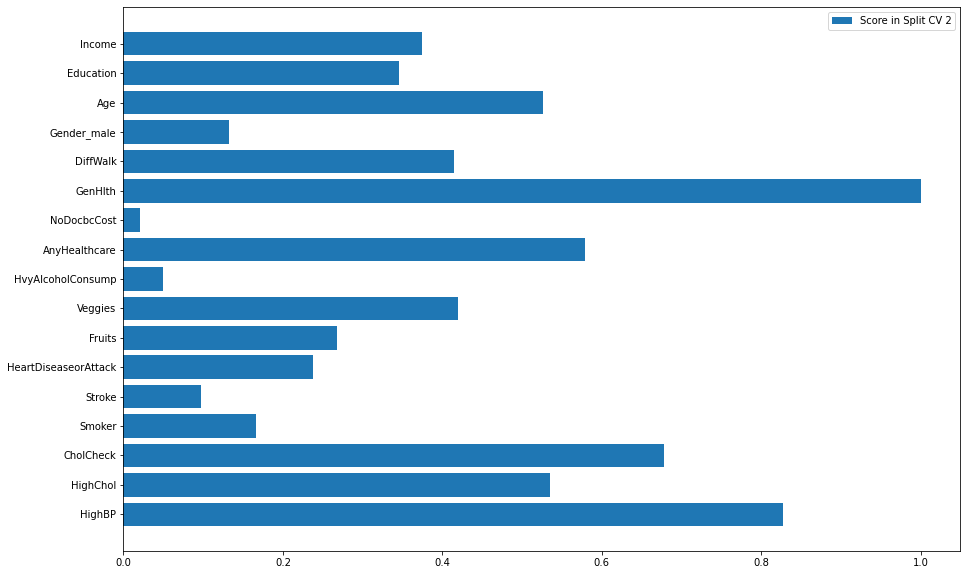

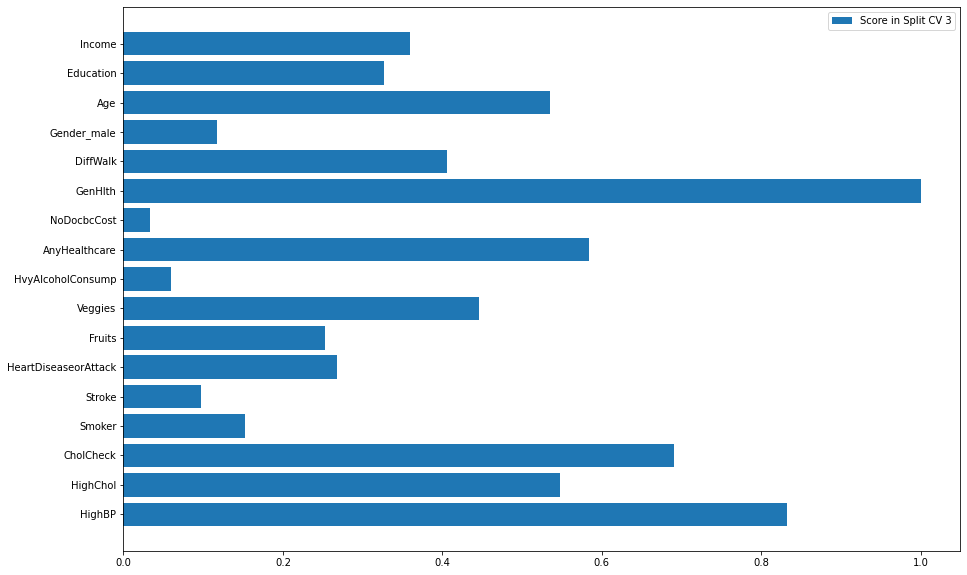

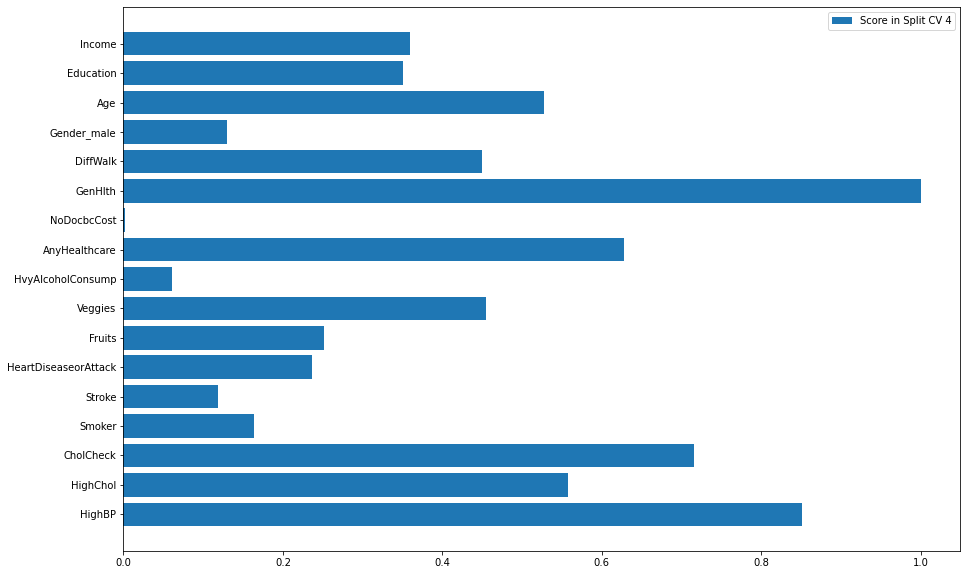

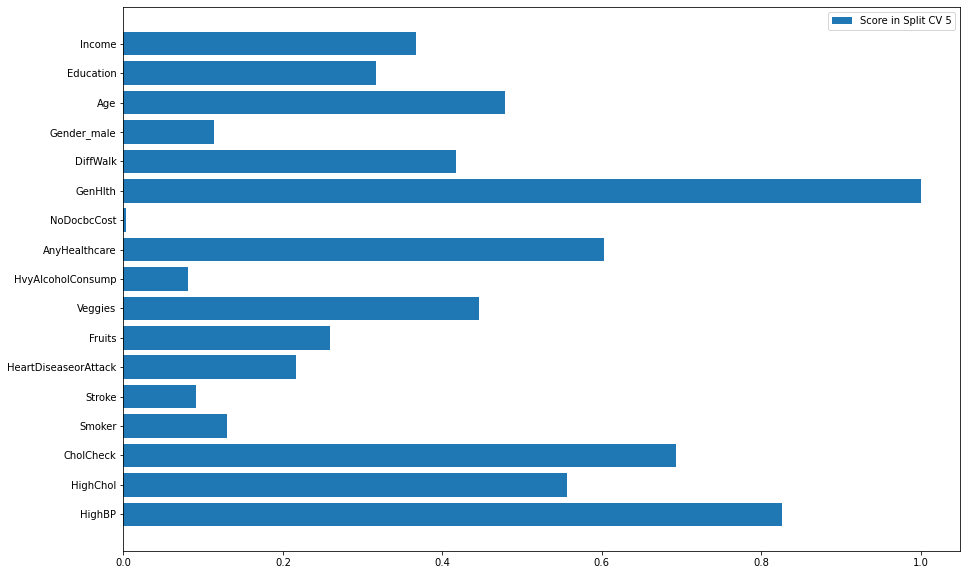

In [82]:
ufs_scaling_cv_plot_score(df_categorical_features, y_value, StandardScaler(), 5, mutual_info_classif)

##### Visualisierung der Scores aus SelectKBest mit StandardScaler (Mutual Info Classification)

Univariate Feature Selection mit Score-Func <function mutual_info_classif at 0x000001A23BA01AF0> und Scaler MinMaxScaler()


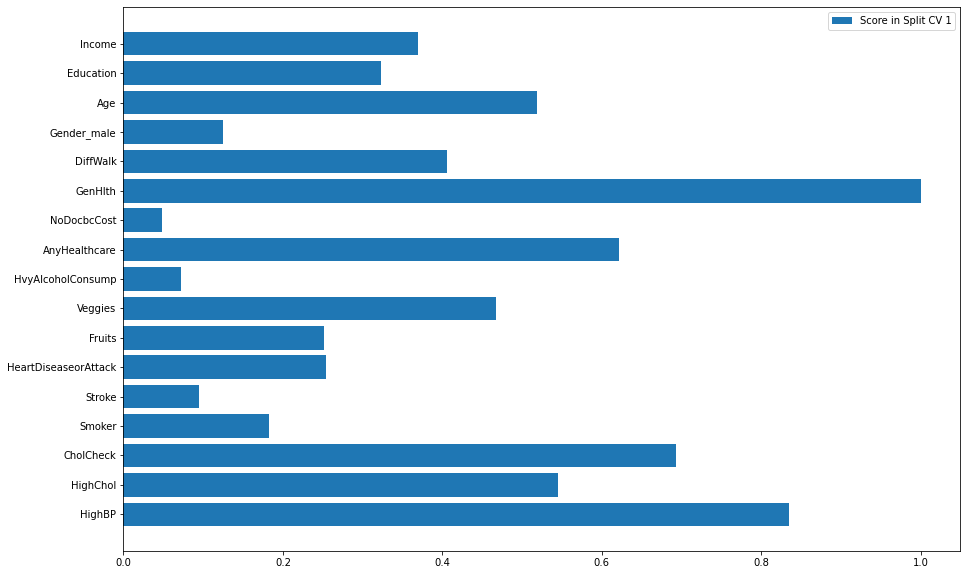

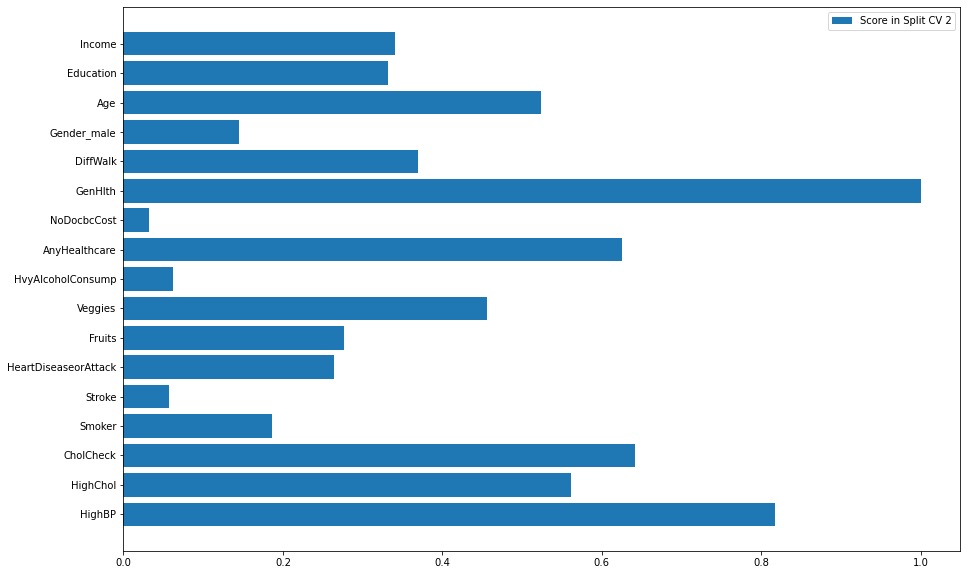

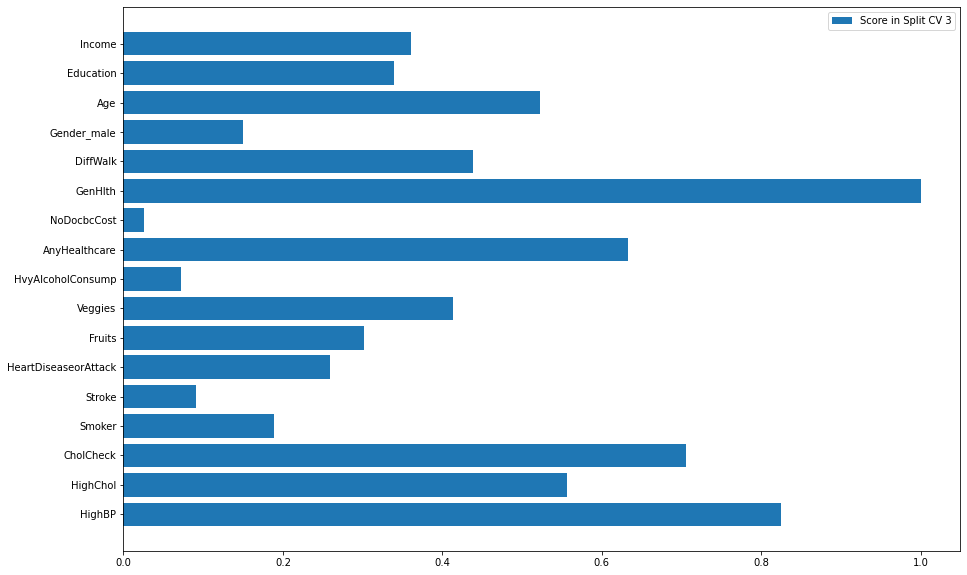

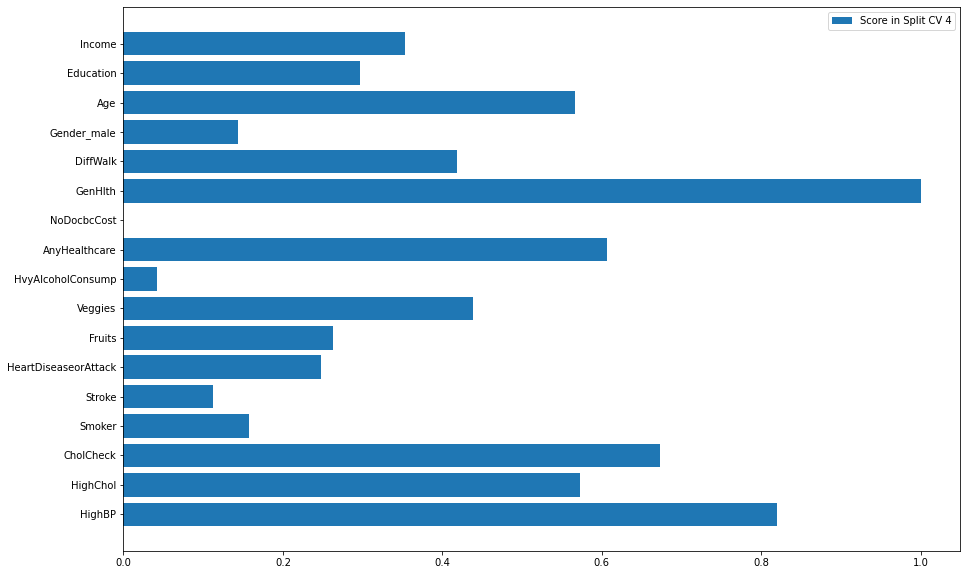

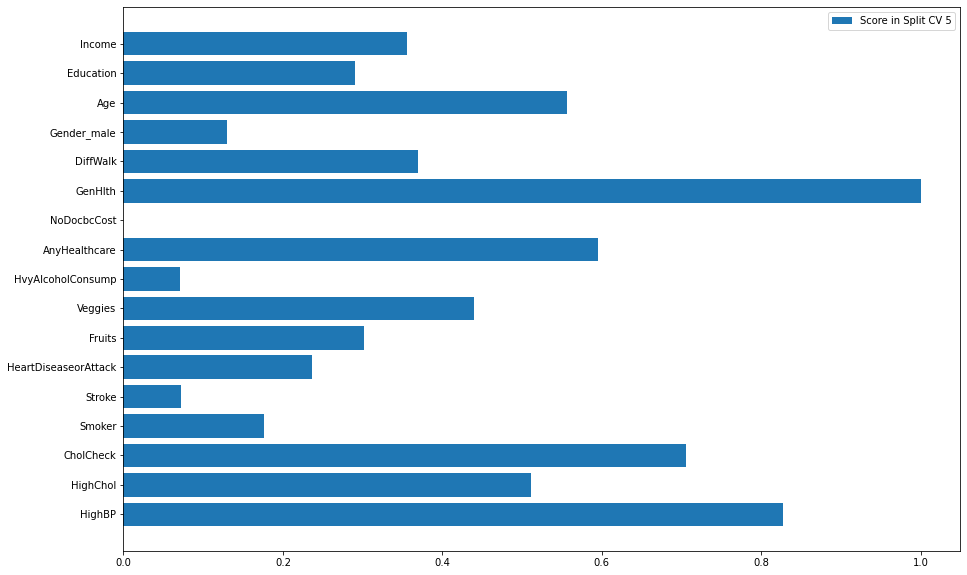

In [177]:
ufs_scaling_cv_plot_score(df_categorical_features, y_value, MinMaxScaler(), 5, mutual_info_classif)

##### Quellen zum Code (Feature Selection - SelectKBest)
*https://machinelearningmastery.com/feature-selection-with-categorical-data/*

#### 3.3.2.2 Auswahl der wichtigsten numerischen Features

##### Visualisierung der Scores aus SelectKBest mit StandardScaler (ANOVA)

Univariate Feature Selection mit Score-Func <function f_classif at 0x000001A23B688940> und Scaler StandardScaler()


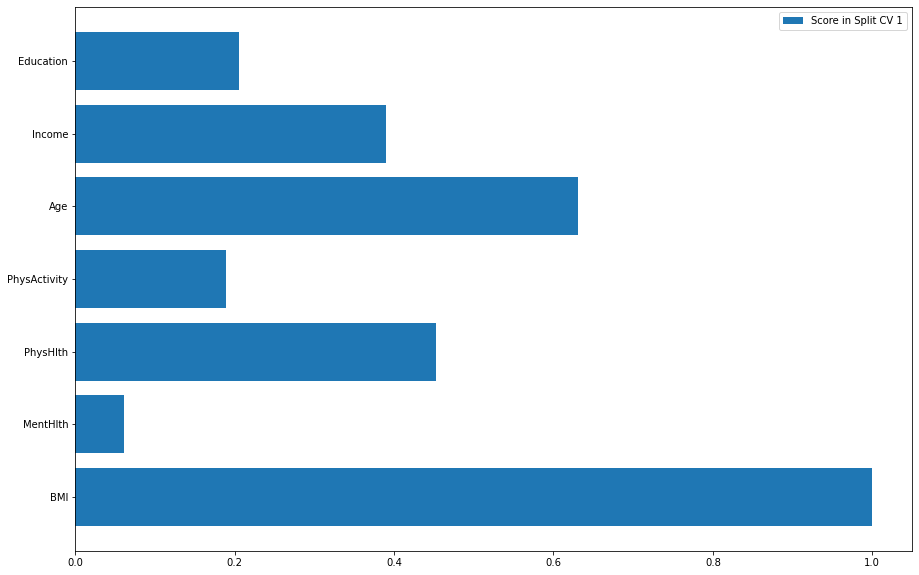

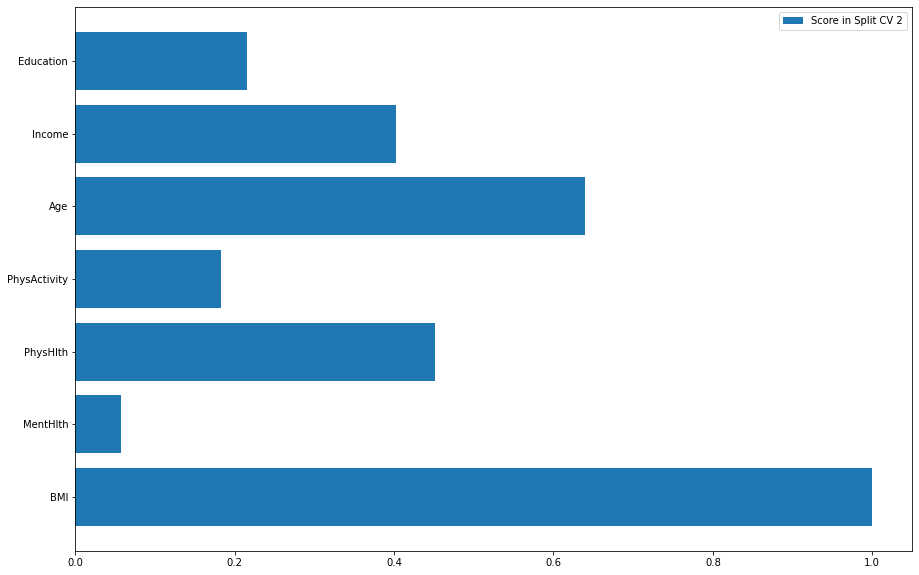

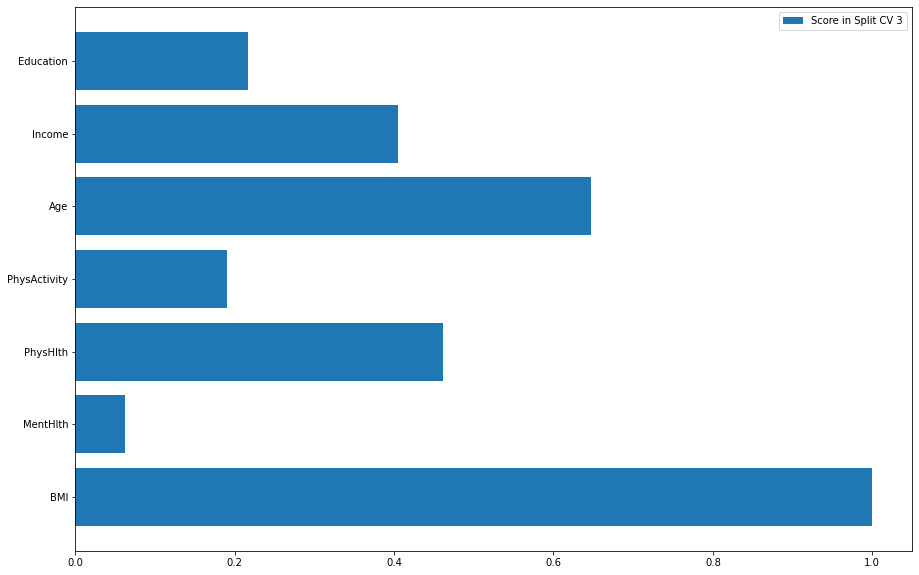

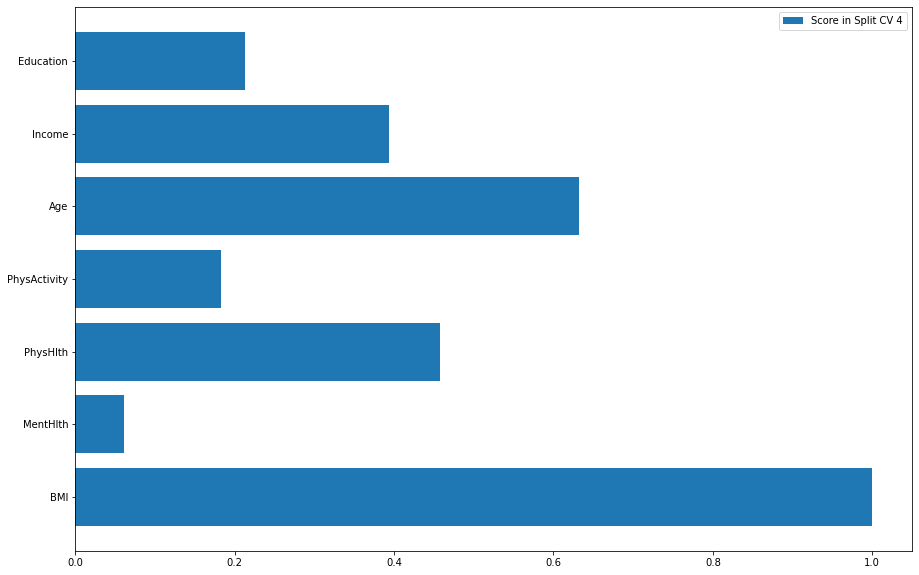

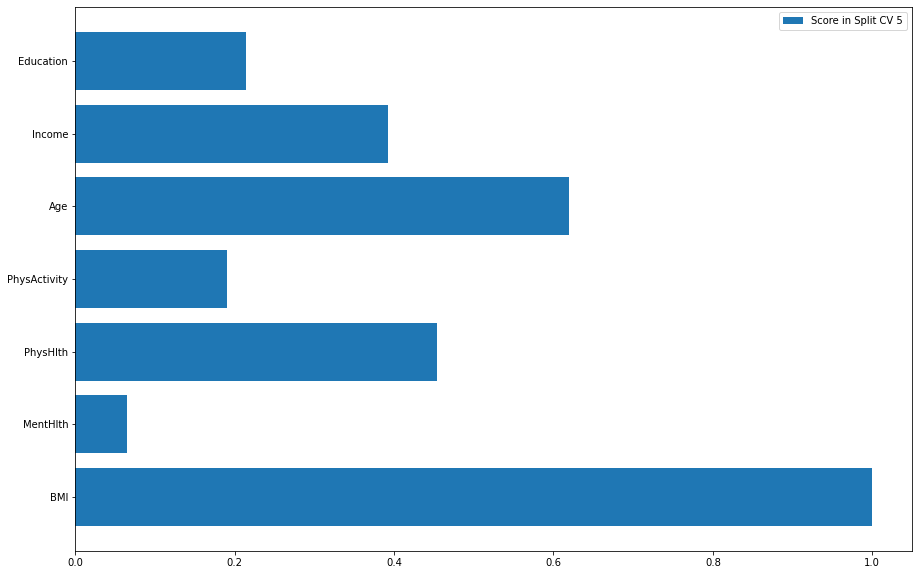

In [178]:
numerical_features = ['BMI', 'MentHlth', 'PhysHlth', 'PhysActivity', 'Age', 'Income', 'Education']
df_numerical_features = df[numerical_features]

# f_classif --> ANOVA
ufs_scaling_cv_plot_score(df_numerical_features, y_value, StandardScaler(), 5, f_classif)

### 3.3.3 Feature Importance 

Bei Anwendung der Recursive Feature Elimination läuft im Hintergrund immer ein Machine Learning Algorithmus, der iterativ die am wenigsten wichtigen Features eliminiert, um das optimale Ergebnis zu erzielen. Hierzu muss der Algorithmus über ein Attribut namens 'coef_' oder 'feature_importances_' verfügen, in der die Werte enthalten sind, die der RFE-Algorithmus zur Eliminierung der einzelnen Features braucht. Durch RFECV kann mithilfe des 'n_features_' Attributes eine erste Idee über die optimale Anzahl an Features für das optimale Modell erlangt werden. RFE kann durch die Attribute 'ranking_' bzw 'support_' einen detaillierteren Einblick in die tatsächliche Feature Importance geben, die im Endeffekt hinter der Feature Selection steckt. 

Ein direkter Zugriff auf das 'feature_importances_'-Attribut des Algorithmus, ohne Einbindung in 'Wrapper Feature Selection'-Algorithmen, wie z.B. RFE, kann eine noch genauere Einsicht in die Ergebnisse liefern und bietet weitere Visualisierungsmöglichkeiten der Ergebnisse.

##### Funktion zur Berechnung und Visualisierung der Feature Importance aus Modellen

In [29]:
def plot_model_feature_importance(x_values, y_value, estimator, cv):
    model = estimator
    cv = cv
    split_counter = 1
    for train_index, test_index in skf.split(x_values, y_value):
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        model.fit(X_train, y_train)
        importance = model.feature_importances_
        plt.figure(figsize=(15,15))
        features = list(x_values.columns)
        plt.barh(features, importance, label='Score in Split CV ' + str(split_counter))
        plt.yticks(np.arange(0, len(features), step=1), features)
        plt.legend(loc='upper right')
        plt.show()
        split_counter += 1

#### 3.3.3.1 RandomForest Classifier - Feature Importance

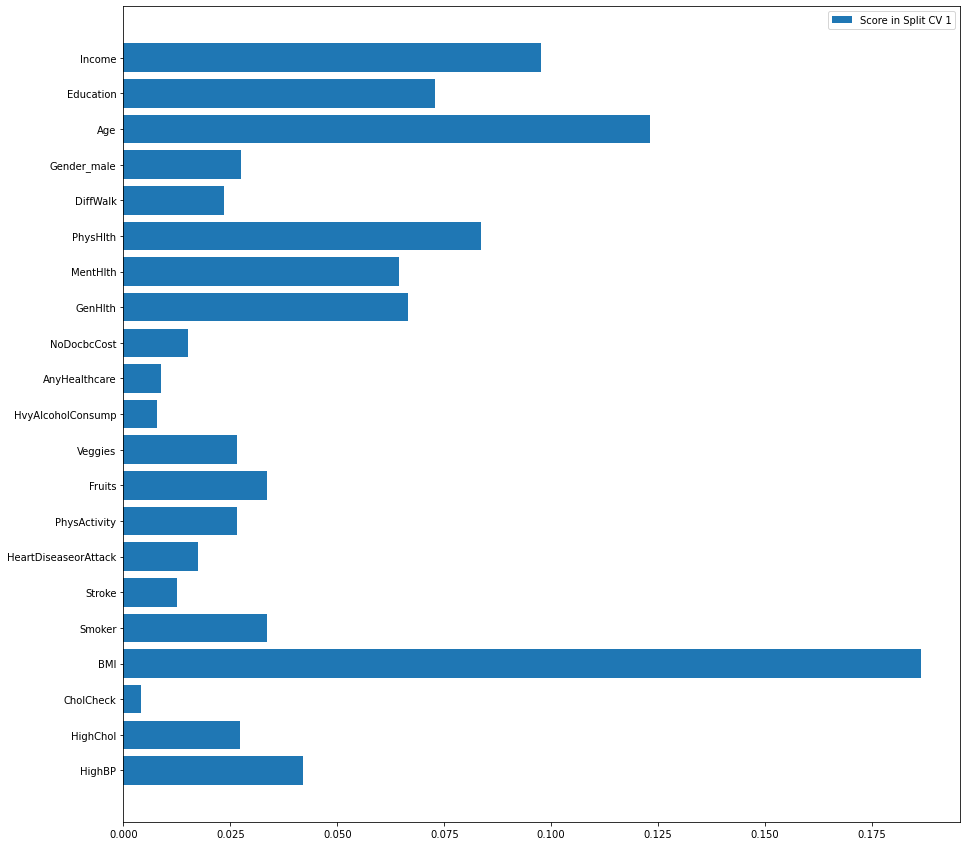

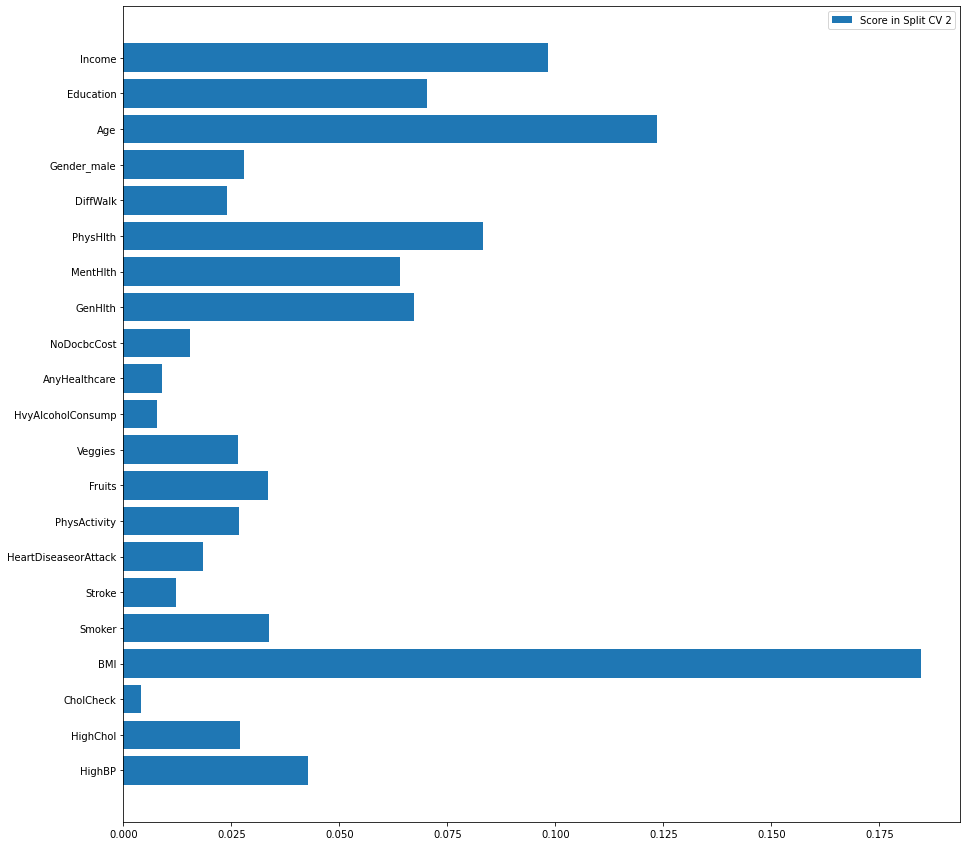

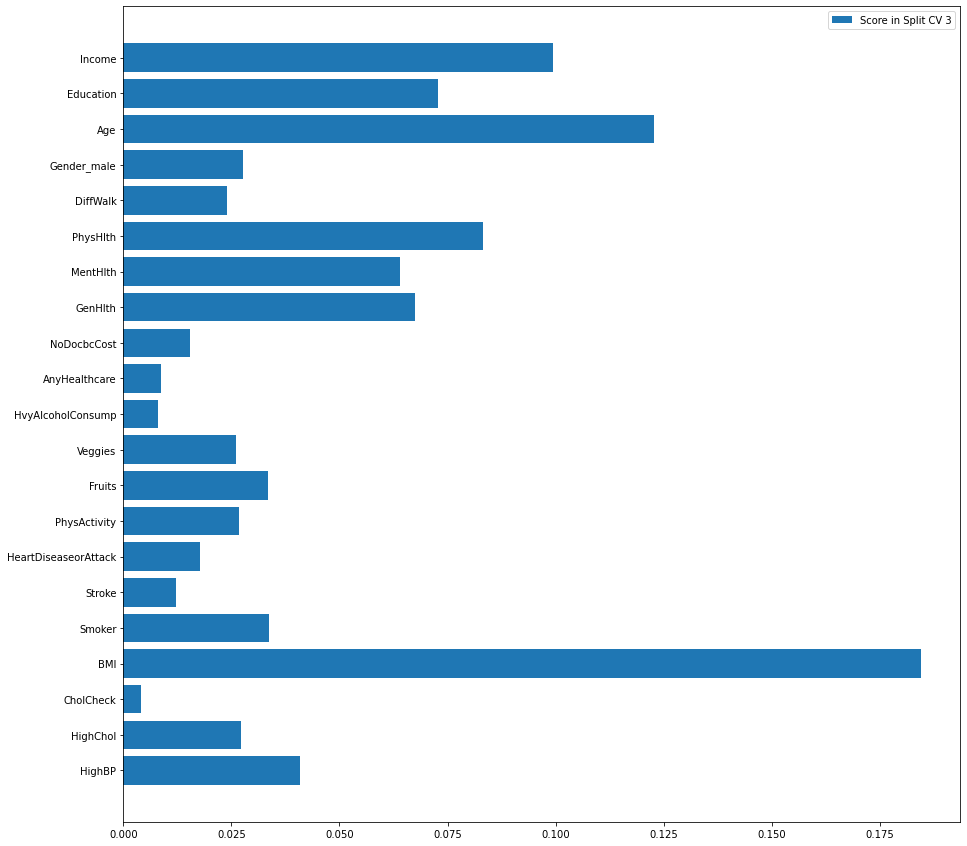

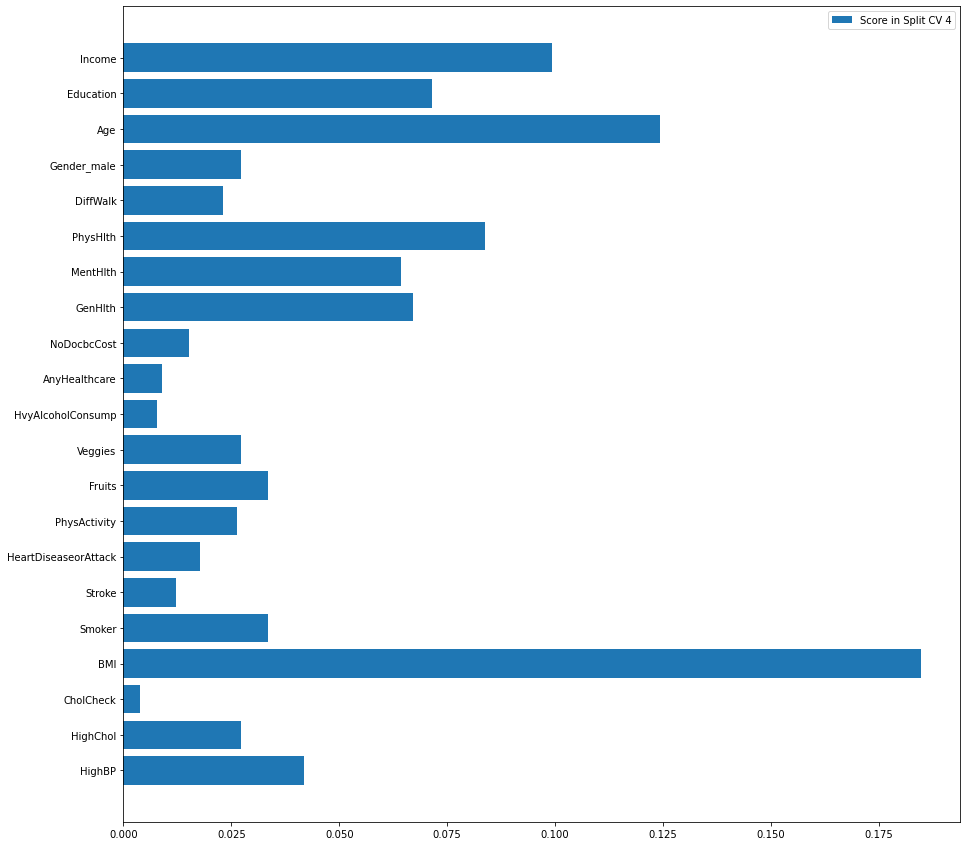

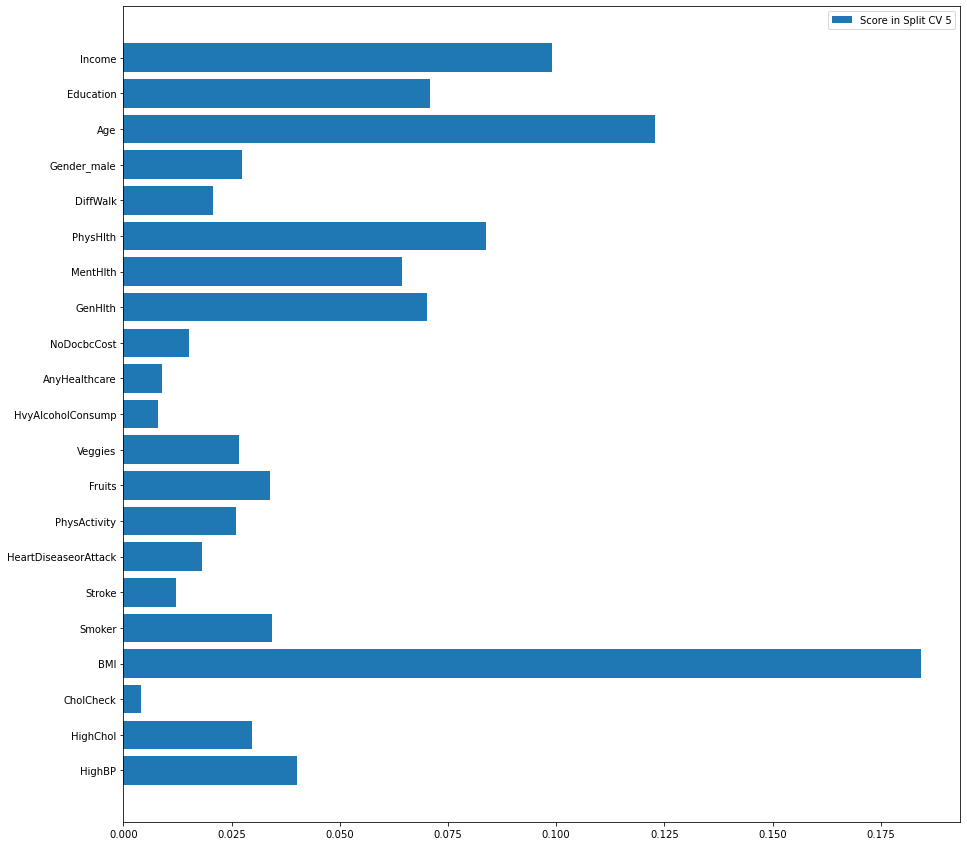

In [35]:
model = RandomForestClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plot_model_feature_importance(x_values_mm, y_value, model, skf)

#### 3.3.3.2 XGBoost Feature Importance

##### Quellen

*https://machinelearningmastery.com/feature-selection-machine-learning-python/*

*https://machinelearningmastery.com/calculate-feature-importance-with-python/*

# 4. Modelling - Machine Learning

## 4.1 Logistische Regression

### 4.1.1 Erste Betrachtung mit GridSearchCV

In [19]:
logreg_parameters = [{'solver': ['sag', 'saga', 'lbfgs'], 'max_iter': [100, 1000, 5000], 'C': [0.01, 0.1, 1.0]}]
                            
logreg_model = LogisticRegression()

logreg_gsvb = GridSearchCV(logreg_model, logreg_parameters, verbose=3, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))

logreg_gsvb.fit(x_values_mm, y_value)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.262 total time=   0.9s
[CV 2/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.263 total time=   0.9s
[CV 3/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.269 total time=   1.0s
[CV 4/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.262 total time=   0.9s
[CV 5/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.254 total time=   0.9s
[CV 1/5] END .C=0.01, max_iter=100, solver=saga;, score=0.262 total time=   1.2s
[CV 2/5] END .C=0.01, max_iter=100, solver=saga;, score=0.263 total time=   1.3s
[CV 3/5] END .C=0.01, max_iter=100, solver=saga;, score=0.269 total time=   1.2s
[CV 4/5] END .C=0.01, max_iter=100, solver=saga;, score=0.262 total time=   1.2s
[CV 5/5] END .C=0.01, max_iter=100, solver=saga;, score=0.253 total time=   1.2s
[CV 1/5] END C=0.01, max_iter=100, solver=lbfgs;, score=0.262 total time=   0.3s
[CV 2/5] END C=0.01, max_iter=100, solver=lbfgs

[CV 2/5] END .C=1.0, max_iter=100, solver=lbfgs;, score=0.284 total time=   0.4s
[CV 3/5] END .C=1.0, max_iter=100, solver=lbfgs;, score=0.293 total time=   0.4s
[CV 4/5] END .C=1.0, max_iter=100, solver=lbfgs;, score=0.285 total time=   0.4s
[CV 5/5] END .C=1.0, max_iter=100, solver=lbfgs;, score=0.277 total time=   0.5s
[CV 1/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.286 total time=   1.9s
[CV 2/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.285 total time=   1.7s
[CV 3/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.293 total time=   2.1s
[CV 4/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.285 total time=   2.0s
[CV 5/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.277 total time=   1.8s
[CV 1/5] END .C=1.0, max_iter=1000, solver=saga;, score=0.286 total time=   1.2s
[CV 2/5] END .C=1.0, max_iter=1000, solver=saga;, score=0.284 total time=   1.2s
[CV 3/5] END .C=1.0, max_iter=1000, solver=saga;, score=0.293 total time=   1.3s
[CV 4/5] END .C=1.0, max_ite

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid=[{'C': [0.01, 0.1, 1.0], 'max_iter': [100, 1000, 5000],
                          'solver': ['sag', 'saga', 'lbfgs']}],
             scoring='f1', verbose=3)

In [154]:
print(f'Das beste Ergebnis der logistischen Regression wurde mit den Parameter {logreg_gsvb.best_params_} erzielt\nmit einem f1-Score von {logreg_gsvb.best_score_}')

Das beste Ergebnis der logistischen Regression wurde mit den Parameter {'C': 1.0, 'max_iter': 5000, 'solver': 'sag'} erzielt
mit einem f1-Score von 0.2852147548335268


### 4.1.2 Optimierung des besten Modells (logistische Regression)

#### 4.1.2.1 Anpassung des 'class_weight'-Parameters

In [80]:
logreg_balanced = LogisticRegression(C=1.0, solver='sag', penalty='l2', max_iter=5000, class_weight='balanced')
print(np.mean(cross_val_score(logreg_balanced, x_values_mm, y_value, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1')))

0.47735035132972337


#### 4.1.2.2 Nutzung der OneHotEncoding Features (skaliert mit MinMaxScaler)

In [34]:
print(np.mean(cross_val_score(logreg_balanced, x_values_encoded_mm, y_value, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1')))

0.4766982242163988


#### 4.1.2.3 Nutzung der wichtigsten Features

In [35]:
# Vorbereitung der wichtigsten Variablen
df_important_encoded = df_encoded[['BMI', 'HighBP', 'HighChol', 'Age', 'GenHlth_2.0', 'GenHlth_3.0', 'GenHlth_4.0', 'GenHlth_5.0',
                                  'Smoker', 'MentHlth', 'PhysHlth']]

x_important_encoded_mm = scale_x_values(df_important_encoded, MinMaxScaler())

In [36]:
print(np.mean(cross_val_score(logreg_balanced, x_important_encoded_mm, y_value, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1')))

0.4702290376079669


#### 4.1.2.3 Oversampling des Datensatzes mittels SMOTE + KFold Cross Validation

##### class_weight = 'balanced'

In [82]:
np.mean(cross_val_score(logreg_balanced, x_smote, y_smote, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='f1'))

0.7457457613960405

##### class_weight = None

In [26]:
logreg_unbalanced = LogisticRegression(C=1.0, solver='sag', penalty='l2', max_iter=5000)
np.mean(cross_val_score(logreg_unbalanced, x_smote, y_smote, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='f1'))

0.7458081742930956

#### 4.1.2.4 Nutzung des skalierten Datensatzes (SMOTE-Oversampling)

##### StandardScaler

In [24]:
x_smote_ss = scale_x_values(x_smote, StandardScaler())

In [27]:
np.mean(cross_val_score(logreg_unbalanced, x_smote_ss, y_smote, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='f1'))

0.7458185481043895

##### MinMaxScaler

In [28]:
x_smote_mm = scale_x_values(x_smote, MinMaxScaler())

In [29]:
np.mean(cross_val_score(logreg_unbalanced, x_smote_mm, y_smote, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='f1'))

0.7457880616589667

#### 4.1.2.5 Kombination aus Over- und Undersampling

In [62]:
np.mean(cross_val_score(logreg_unbalanced, x_ou_combi, y_ou_combi, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='f1'))

0.7419945090971165

*https://medium.com/analytics-vidhya/how-to-improve-logistic-regression-b956e72f4492*

*https://medium.com/analytics-vidhya/why-use-logistic-regression-6cd17e09e6d0*

*https://medium.com/analytics-vidhya/how-to-implement-logistic-regression-6f27ce4c45fd*

## 4.2 Random Forest Classfier

### 4.2.1 Erste Betrachtung mit RandomSearchCV

In [137]:
rfc_parameters = [{'n_estimators': [10, 100, 1000], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 20],
                  'max_features': ['auto', 'sqrt'], 'min_samples_split': [2,4,6], 'min_samples_leaf': [1, 2, 4]}]

rfc_model = RandomForestClassifier(class_weight='balanced')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfc_rscv = RandomizedSearchCV(estimator=rfc_model, n_iter=10, scoring='f1', cv=cv, param_distributions=rfc_parameters, verbose=2)

rfc_rscv.fit(x_values, y_value)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.9s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.9s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.9s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.9s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time= 2.5min
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_e

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'entropy'}

In [172]:
print(f'Das beste Ergebnis der Random Forest Classification wurde mit den Parameter {rfc_rscv.best_params_} erzielt\nmit einem f1-Score von {rfc_rscv.best_score_}')

Das beste Ergebnis der Random Forest Classification wurde mit den Parameter {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'} erzielt
mit einem f1-Score von 0.486184558103295


### 4.2.2 Optimierung des besten Modells (RandomForestClassifier)

In [67]:
rfc_best = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=20, criterion='entropy')

#### 4.2.2.1 SMOTE-Oversampling

In [51]:
print(cross_val_score(rfc_best, x_smote, y_smote, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1'))

[0.88585924 0.88375657 0.88418748 0.88298251 0.88337877]


In [ ]:
# OverBagging, UnderBagging und OverUnderBagging s. Link

#### 4.2.2.2 Kombination aus Over- und  Undersampling

In [68]:
cross_val_score(rfc_best, x_ou_combi, y_ou_combi, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1')

array([0.81915955, 0.8220216 , 0.82210839, 0.82144297, 0.82378997])

## 4.3 Support Vektor Classifier

##### Quellen 

*https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/*

*https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/*

*https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd*

*https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/*

# 5. Evaluation - Machine Learning

##### Funktionen zur Erstellung einer Konfusionsmatrix über mehrere Cross-Validation-Splits

In [95]:
def cross_val_predict(model, kfold, x_values, y_value):

    # model_ = cp.deepcopy(model)
    
    # no_classes = len(np.unique(y_value))
    
    actual_classes = np.array([])
    predicted_classes = np.array([])
    # predicted_proba = np.array([]) 

    for train_index, test_index in kfold.split(x_values, y_value):

        X_train, y_train = x_values.iloc[train_index], y_value.iloc[train_index]
        X_test, y_test = x_values.iloc[test_index], y_value.iloc[test_index]
        
        actual_classes = np.append(actual_classes, y_test)

        model.fit(X_train, y_train)
        
        predicted_classes = np.append(predicted_classes, model.predict(X_test))

#         try:
#             predicted_proba = np.append(predicted_proba, model.predict_proba(X_test))
#         except:
#             predicted_proba = np.append(predicted_proba, np.zeros((len(X_test), no_classes)), axis=0)

    # return actual_classes, predicted_classes, predicted_proba
    return actual_classes, predicted_classes

def plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels):

    matrix = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

## 5.1 Evaluation - Logistische Regression

### 5.1.1 Konfusionsmatrix über alle Cross Validation Splits

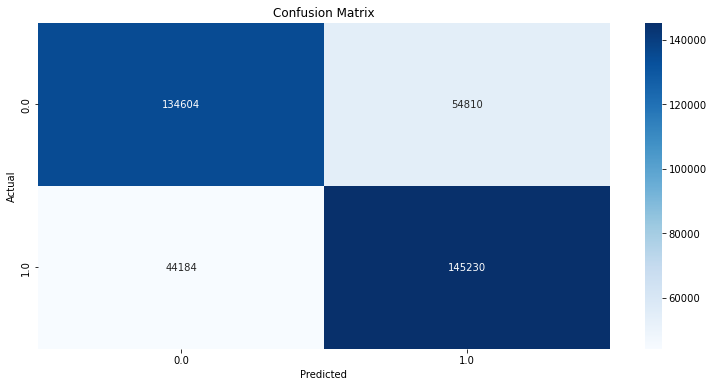

In [88]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

actual_classes_logreg, predicted_classes_logreg, predicted_proba_logreg = cross_val_predict(logreg_unbalanced, cv, x_smote, y_smote)
plot_confusion_matrix(actual_classes_logreg, predicted_classes_logreg, ['0.0', '1.0'])

##### Quellen zum Code

*https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874*

*https://medium.com/analytics-vidhya/generation-of-a-concatenated-confusion-matrix-in-cross-validation-912485c4a972*

### 5.1.2 Klassifikationsmessgrößen (logistische Regression)

#### 5.1.2.1 Accuracy (logistische Regression)

In [75]:
accuracy_score(actual_classes_logreg, predicted_classes_logreg)

0.738675599480503

#### 5.1.2.2 Precision/ Positive Predictive Value (logistische Regression)

In [76]:
precision_score(actual_classes_logreg, predicted_classes_logreg)

0.7260006898723737

#### 5.1.2.3 Recall Score/ Sensitivität/ True Positive Rate (logistische Regression)

In [77]:
recall_score(actual_classes_logreg, predicted_classes_logreg)

0.7667173492983623

#### 5.1.2.4 f1-Score (logistische Regression)

In [78]:
f1_score(actual_classes_logreg, predicted_classes_logreg)

0.7458037082970643

### 5.1.3 ROC-Kurve und AUC für mehrere Cross-Validation-Splits (logistische Regression)

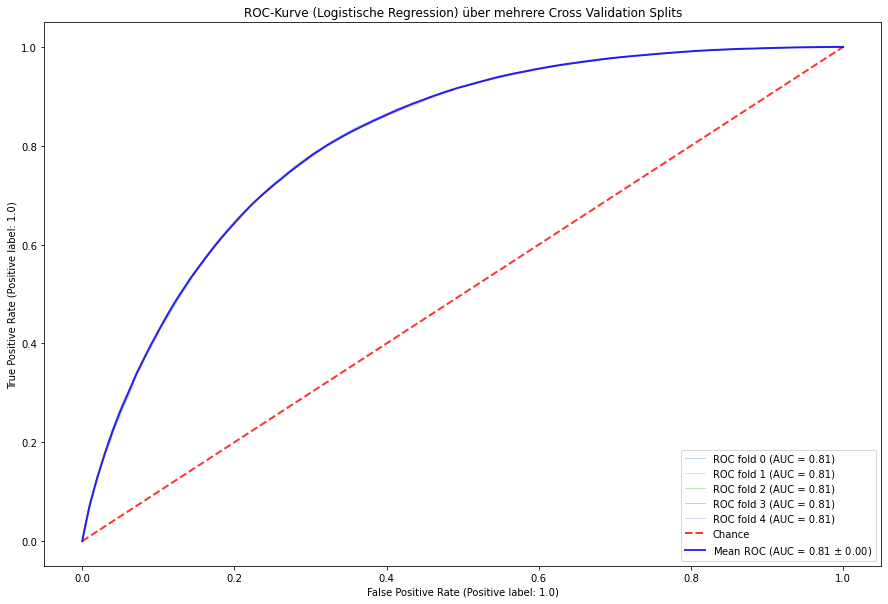

In [112]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
classifier = logreg_unbalanced

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15,10))
for i, (train, test) in enumerate(cv.split(x_smote, y_smote)):
    classifier.fit(x_smote.iloc[train], y_smote.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x_smote.iloc[test],
        y_smote.iloc[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC-Kurve (Logistische Regression) über mehrere Cross Validation Splits",
)

ax.legend(loc="lower right")
plt.show()

##### Quellen zum Code

*https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#:~:text=Example%20of%20Receiver%20Operating%20Characteristic,rate%20on%20the%20X%20axis.*

## 5.2 Evaluation - Random Forest Classifier

##### Quellen

*https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226*

*https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-models-e2f0d8009d69*

*https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/#:~:text=Metrics%20like%20accuracy%2C%20precision%2C%20recall,in%20evaluating%20the%20model%20performance.*

*https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/#:~:text=The%20F%2DMeasure%20is%20a,by%20a%20coefficient%20called%20beta.*

*https://medium.com/datasciencestory/performance-metrics-for-evaluating-a-model-on-an-imbalanced-data-set-1feeab6c36fe*

# 6. Modelling - Deep Learning

In [47]:
def neural_network_cv(x_values, y_values, cv, num_hidden_layer, num_neurons, activation, activation_output, loss, epochs, learningrate, scaler):
    accuracy_arr_train = []
    accuracy_arr_test = []
    
    for train_index, test_index in skf.split(x_values_mm, y_value):
        X_train, X_test = x_values_mm.iloc[train_index], x_values_mm.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        if scaler != None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
        model = keras.Sequential()
        model.add(keras.layers.Input(x_values.shape[1]))
        
        for _ in range(num_hidden_layer):
            model.add(keras.layers.Dense(num_neurons, activation=activation))
            
        model.add(keras.layers.Dense(1, activation=activation_output))
        
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
        model.compile(loss=loss, optimizer=opt, metrics=[f1, "accuracy"])
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

        train_acc = model.evaluate(X_train, y_train)
        test_acc = model.evaluate(X_test, y_test)
        accuracy_arr_train.append(train_acc)
        accuracy_arr_test.append(test_acc)
    return accuracy_arr_train, accuracy_arr_test

## 6.1 Erste Betrachtung eines Neuronalen Netzwerkes

#### Initialisierung wichtiger Werte

In [1]:
num_hidden_layer = 3
num_neurons = 32
num_folds = 5
activation = "relu"
loss = 'kullback_leibler_divergence'
epochs = 5
lr = 1e-5

##### Erster Durchlauf des Modells

In [23]:
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_arr_train = []
accuracy_arr_test = []

for train_index, test_index in skf.split(x_values_mm, y_value):
    X_train, X_test = x_values_mm.iloc[train_index], x_values_mm.iloc[test_index]
    y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    model = keras.Sequential()
    model.add(keras.layers.Input(x_values.shape[1]))
    for _ in range(num_hidden_layer):
        model.add(keras.layers.Dense(num_neurons, activation=activation))
    model.add(keras.layers.Dense(1, activation=activation))

    opt = keras.optimizers.Adam(learning_rate=lr)
    f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=[f1, "accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    train_acc = model.evaluate(X_train, y_train)
    test_acc = model.evaluate(X_test, y_test)
    accuracy_arr_train.append(train_acc)
    accuracy_arr_test.append(test_acc)

Epoch 1/5
4578/4578 [==============================] - 6s 1ms/step - loss: 0.1448 - f1_score: 0.2888 - accuracy: 0.5320 - val_loss: 0.0086 - val_f1_score: 0.2987 - val_accuracy: 0.1945
Epoch 2/5
4578/4578 [==============================] - 5s 1ms/step - loss: 0.0022 - f1_score: 0.2954 - accuracy: 0.1783 - val_loss: 4.5771e-04 - val_f1_score: 0.2944 - val_accuracy: 0.1739
Epoch 3/5
4578/4578 [==============================] - 5s 1ms/step - loss: 1.5747e-04 - f1_score: 0.2943 - accuracy: 0.1730 - val_loss: 8.7512e-05 - val_f1_score: 0.2941 - val_accuracy: 0.1726
Epoch 4/5
4578/4578 [==============================] - 5s 1ms/step - loss: 2.5586e-05 - f1_score: 0.2942 - accuracy: 0.1725 - val_loss: 2.5736e-05 - val_f1_score: 0.2941 - val_accuracy: 0.1724
Epoch 5/5
1431/1431 [==============================] - 1s 761us/step - loss: 2.2718e-07 - f1_score: 0.2941 - accuracy: 0.1725
Epoch 1/5
4578/4578 [==============================] - 5s 1ms/step - loss: 0.0413 - f1_score: 0.2966 - accuracy: 0

## 6.2 Verwendung unterschiedlicher Daten zur möglichen Optimierung des Modells

### 6.2.1 Gemischtes Over-/ und Undersampling

##### StratifiedKFold

In [24]:
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_arr_train = []
accuracy_arr_test = []

for train_index, test_index in skf.split(x_ou_combi, y_ou_combi):
    X_train, X_test = x_ou_combi.iloc[train_index], x_ou_combi.iloc[test_index]
    y_train, y_test = y_ou_combi.iloc[train_index], y_ou_combi.iloc[test_index]
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    model = keras.Sequential()
    model.add(keras.layers.Input(x_values.shape[1]))
    for _ in range(num_hidden_layer):
        model.add(keras.layers.Dense(num_neurons, activation=activation))
    model.add(keras.layers.Dense(1, activation=activation))

    opt = keras.optimizers.Adam(learning_rate=lr)
    f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=[f1, "accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    train_acc = model.evaluate(X_train, y_train)
    test_acc = model.evaluate(X_test, y_test)
    accuracy_arr_train.append(train_acc)
    accuracy_arr_test.append(test_acc)

Epoch 1/5
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0161 - f1_score: 0.6652 - accuracy: 0.4997 - val_loss: 7.4944e-04 - val_f1_score: 0.6703 - val_accuracy: 0.5042
Epoch 2/5
3789/3789 [==============================] - 4s 1ms/step - loss: 6.4173e-04 - f1_score: 0.6658 - accuracy: 0.4991 - val_loss: 2.7607e-05 - val_f1_score: 0.6703 - val_accuracy: 0.5041
Epoch 3/5
3789/3789 [==============================] - 4s 1ms/step - loss: 2.7247e-05 - f1_score: 0.6658 - accuracy: 0.4990 - val_loss: -7.9928e-07 - val_f1_score: 0.6703 - val_accuracy: 0.5041
Epoch 4/5
3789/3789 [==============================] - 4s 1ms/step - loss: 6.9201e-06 - f1_score: 0.6658 - accuracy: 0.4990 - val_loss: -7.9928e-07 - val_f1_score: 0.6703 - val_accuracy: 0.5041
Epoch 5/5
1184/1184 [==============================] - 1s 772us/step - loss: -8.0593e-07 - f1_score: 0.6667 - accuracy: 0.5000
Epoch 1/5
3789/3789 [==============================] - 5s 1ms/step - loss: 1.4316 - f1_score: 0.6103 - 

##### KFold (mit mehr Folds) + mehr Epochen

In [36]:
epochs = 10
num_folds = 10

skf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_arr_train = []
accuracy_arr_test = []

for train_index, test_index in skf.split(x_ou_combi, y_ou_combi):
    X_train, X_test = x_ou_combi.iloc[train_index], x_ou_combi.iloc[test_index]
    y_train, y_test = y_ou_combi.iloc[train_index], y_ou_combi.iloc[test_index]
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    model = keras.Sequential()
    model.add(keras.layers.Input(x_values.shape[1]))
    for _ in range(num_hidden_layer):
        model.add(keras.layers.Dense(num_neurons, activation=activation))
    model.add(keras.layers.Dense(1, activation=activation))

    opt = keras.optimizers.Adam(learning_rate=lr)
    f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=[f1, "accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    train_acc = model.evaluate(X_train, y_train)
    test_acc = model.evaluate(X_test, y_test)
    accuracy_arr_train.append(train_acc)
    accuracy_arr_test.append(test_acc)

Epoch 1/10
4262/4262 [==============================] - 6s 1ms/step - loss: 3.5844 - f1_score: 0.4905 - accuracy: 0.5143 - val_loss: 0.5148 - val_f1_score: 0.6403 - val_accuracy: 0.5138
Epoch 2/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.2660 - f1_score: 0.6521 - accuracy: 0.5096 - val_loss: 0.1091 - val_f1_score: 0.6655 - val_accuracy: 0.5128
Epoch 3/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.0409 - f1_score: 0.6648 - accuracy: 0.5044 - val_loss: 0.0043 - val_f1_score: 0.6700 - val_accuracy: 0.5055
Epoch 4/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.0016 - f1_score: 0.6665 - accuracy: 0.5007 - val_loss: 6.4594e-04 - val_f1_score: 0.6699 - val_accuracy: 0.5039
Epoch 5/10
4262/4262 [==============================] - 5s 1ms/step - loss: 3.8927e-04 - f1_score: 0.6663 - accuracy: 0.4998 - val_loss: 1.0026e-04 - val_f1_score: 0.6697 - val_accuracy: 0.5035
Epoch 6/10
4262/4262 [==============================] - 5s

Epoch 10/10
592/592 [==============================] - 0s 813us/step - loss: 8.1067 - f1_score: 0.0000e+00 - accuracy: 0.4970
Epoch 1/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.5258 - f1_score: 0.6426 - accuracy: 0.5086 - val_loss: 0.0047 - val_f1_score: 0.6721 - val_accuracy: 0.5082
Epoch 2/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.0028 - f1_score: 0.6663 - accuracy: 0.5010 - val_loss: 0.0013 - val_f1_score: 0.6721 - val_accuracy: 0.5068
Epoch 3/10
4262/4262 [==============================] - 5s 1ms/step - loss: 4.3605e-04 - f1_score: 0.6660 - accuracy: 0.4994 - val_loss: 1.1757e-04 - val_f1_score: 0.6718 - val_accuracy: 0.5058
Epoch 4/10
4262/4262 [==============================] - 5s 1ms/step - loss: 2.1207e-05 - f1_score: 0.6659 - accuracy: 0.4991 - val_loss: 7.0955e-06 - val_f1_score: 0.6717 - val_accuracy: 0.5057
Epoch 5/10
4262/4262 [==============================] - 5s 1ms/step - loss: 2.6619e-06 - f1_score: 0.6659 - accura

Epoch 8/10
4262/4262 [==============================] - 5s 1ms/step - loss: -8.0718e-07 - f1_score: 0.6660 - accuracy: 0.4992 - val_loss: -7.9671e-07 - val_f1_score: 0.6717 - val_accuracy: 0.5057
Epoch 9/10
4262/4262 [==============================] - 5s 1ms/step - loss: -8.0718e-07 - f1_score: 0.6660 - accuracy: 0.4992 - val_loss: -7.9671e-07 - val_f1_score: 0.6717 - val_accuracy: 0.5057
Epoch 10/10
592/592 [==============================] - 0s 780us/step - loss: -8.1326e-07 - f1_score: 0.6626 - accuracy: 0.4954
Epoch 1/10
4262/4262 [==============================] - 6s 1ms/step - loss: 7.3102 - f1_score: 0.0917 - accuracy: 0.5141 - val_loss: 6.6935 - val_f1_score: 0.2104 - val_accuracy: 0.5259
Epoch 2/10
4262/4262 [==============================] - 5s 1ms/step - loss: 1.1356 - f1_score: 0.6095 - accuracy: 0.5019 - val_loss: 0.0426 - val_f1_score: 0.6667 - val_accuracy: 0.5058
Epoch 3/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.0158 - f1_score: 0.6641 - accur

### 6.2.2 Verwendung des standartisierten Datensatzes

In [37]:
epochs = 10
num_folds = 10
scaler = MinMaxScaler()

skf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_arr_train = []
accuracy_arr_test = []

for train_index, test_index in skf.split(x_ou_combi, y_ou_combi):
    X_train, X_test = x_ou_combi.iloc[train_index], x_ou_combi.iloc[test_index]
    y_train, y_test = y_ou_combi.iloc[train_index], y_ou_combi.iloc[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    model = keras.Sequential()
    model.add(keras.layers.Input(x_values.shape[1]))
    for _ in range(num_hidden_layer):
        model.add(keras.layers.Dense(num_neurons, activation=activation))
    model.add(keras.layers.Dense(1, activation=activation))

    opt = keras.optimizers.Adam(learning_rate=lr)
    f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=[f1, "accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    train_acc = model.evaluate(X_train, y_train)
    test_acc = model.evaluate(X_test, y_test)
    accuracy_arr_train.append(train_acc)
    accuracy_arr_test.append(test_acc)

Epoch 1/10
4262/4262 [==============================] - 6s 1ms/step - loss: 1.3798 - f1_score: 0.0302 - accuracy: 0.5033 - val_loss: 0.6186 - val_f1_score: 0.1616 - val_accuracy: 0.5112
Epoch 2/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.2522 - f1_score: 0.5956 - accuracy: 0.5434 - val_loss: 0.0228 - val_f1_score: 0.6720 - val_accuracy: 0.5119
Epoch 3/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.0056 - f1_score: 0.6666 - accuracy: 0.5008 - val_loss: 7.4234e-04 - val_f1_score: 0.6697 - val_accuracy: 0.5035
Epoch 4/10
4262/4262 [==============================] - 5s 1ms/step - loss: 2.4997e-04 - f1_score: 0.6661 - accuracy: 0.4994 - val_loss: 6.6512e-05 - val_f1_score: 0.6697 - val_accuracy: 0.5034
Epoch 5/10
4262/4262 [==============================] - 5s 1ms/step - loss: 3.1995e-05 - f1_score: 0.6661 - accuracy: 0.4994 - val_loss: 1.9601e-05 - val_f1_score: 0.6697 - val_accuracy: 0.5034
Epoch 6/10
4262/4262 [============================

Epoch 10/10
592/592 [==============================] - 0s 761us/step - loss: -8.0114e-07 - f1_score: 0.6693 - accuracy: 0.5030
Epoch 1/10
4262/4262 [==============================] - 5s 1ms/step - loss: 4.4504 - f1_score: 0.0000e+00 - accuracy: 0.5009 - val_loss: 1.5099 - val_f1_score: 0.0000e+00 - val_accuracy: 0.4943
Epoch 2/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.8177 - f1_score: 0.0441 - accuracy: 0.5052 - val_loss: 0.4780 - val_f1_score: 0.2667 - val_accuracy: 0.5291
Epoch 3/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.2135 - f1_score: 0.6257 - accuracy: 0.5388 - val_loss: 0.0172 - val_f1_score: 0.6721 - val_accuracy: 0.5066
Epoch 4/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.0042 - f1_score: 0.6660 - accuracy: 0.4995 - val_loss: 7.2806e-04 - val_f1_score: 0.6717 - val_accuracy: 0.5057
Epoch 5/10
4262/4262 [==============================] - 5s 1ms/step - loss: 2.5459e-04 - f1_score: 0.6659 - accuracy:

Epoch 8/10
4262/4262 [==============================] - 5s 1ms/step - loss: -8.0718e-07 - f1_score: 0.6660 - accuracy: 0.4992 - val_loss: -5.2729e-07 - val_f1_score: 0.6717 - val_accuracy: 0.5057
Epoch 9/10
4262/4262 [==============================] - 5s 1ms/step - loss: -8.0718e-07 - f1_score: 0.6660 - accuracy: 0.4992 - val_loss: -5.2733e-07 - val_f1_score: 0.6717 - val_accuracy: 0.5057
Epoch 10/10
592/592 [==============================] - 0s 754us/step - loss: -8.1326e-07 - f1_score: 0.6626 - accuracy: 0.4954
Epoch 1/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.1641 - f1_score: 0.6117 - accuracy: 0.4721 - val_loss: 0.0075 - val_f1_score: 0.6710 - val_accuracy: 0.5051
Epoch 2/10
4262/4262 [==============================] - 5s 1ms/step - loss: 0.0018 - f1_score: 0.6654 - accuracy: 0.4986 - val_loss: 3.1103e-04 - val_f1_score: 0.6712 - val_accuracy: 0.5051
Epoch 3/10
4262/4262 [==============================] - 5s 1ms/step - loss: 7.2674e-05 - f1_score: 0.6653

### 6.2.3 SMOTE-Oversampling

In [38]:
epochs = 5
num_folds = 5
# scaler = MinMaxScaler()

skf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_arr_train = []
accuracy_arr_test = []

for train_index, test_index in skf.split(x_smote, y_smote):
    X_train, X_test = x_smote.iloc[train_index], x_smote.iloc[test_index]
    y_train, y_test = y_smote.iloc[train_index], y_smote.iloc[test_index]
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    model = keras.Sequential()
    model.add(keras.layers.Input(x_smote.shape[1]))
    for _ in range(num_hidden_layer):
        model.add(keras.layers.Dense(num_neurons, activation=activation))
    model.add(keras.layers.Dense(1, activation=activation))

    opt = keras.optimizers.Adam(learning_rate=lr)
    f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=[f1, "accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    train_acc = model.evaluate(X_train, y_train)
    test_acc = model.evaluate(X_test, y_test)
    accuracy_arr_train.append(train_acc)
    accuracy_arr_test.append(test_acc)

Epoch 1/5
7577/7577 [==============================] - 9s 1ms/step - loss: 1.3293 - f1_score: 0.5666 - accuracy: 0.4794 - val_loss: 0.0406 - val_f1_score: 0.6614 - val_accuracy: 0.5021
Epoch 2/5
7577/7577 [==============================] - 8s 1ms/step - loss: 0.0094 - f1_score: 0.6666 - accuracy: 0.5018 - val_loss: 5.1738e-04 - val_f1_score: 0.6651 - val_accuracy: 0.4983
Epoch 3/5
7577/7577 [==============================] - 8s 1ms/step - loss: 1.2447e-04 - f1_score: 0.6669 - accuracy: 0.5003 - val_loss: 1.5752e-06 - val_f1_score: 0.6651 - val_accuracy: 0.4982
Epoch 4/5
7577/7577 [==============================] - 8s 1ms/step - loss: -1.8226e-07 - f1_score: 0.6669 - accuracy: 0.5003 - val_loss: -3.6208e-07 - val_f1_score: 0.6651 - val_accuracy: 0.4982
Epoch 5/5
2368/2368 [==============================] - 2s 782us/step - loss: -8.0490e-07 - f1_score: 0.6672 - accuracy: 0.5006
Epoch 1/5
7577/7577 [==============================] - 9s 1ms/step - loss: 6.8664 - f1_score: 0.1715 - accuracy

## 6.3 Veränderung der Parameter des neuronalen Netzwerks

### 6.3.1 Änderung der Aktivierungsfunktion in der Outputschicht

In [39]:
epochs = 5
num_folds = 5
# scaler = MinMaxScaler()

skf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_arr_train = []
accuracy_arr_test = []

for train_index, test_index in skf.split(x_ou_combi, y_ou_combi):
    X_train, X_test = x_ou_combi.iloc[train_index], x_ou_combi.iloc[test_index]
    y_train, y_test = y_ou_combi.iloc[train_index], y_ou_combi.iloc[test_index]
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    model = keras.Sequential()
    model.add(keras.layers.Input(x_values.shape[1]))
    for _ in range(num_hidden_layer):
        model.add(keras.layers.Dense(num_neurons, activation=activation))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=lr)
    f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=[f1, "accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    train_acc = model.evaluate(X_train, y_train)
    test_acc = model.evaluate(X_test, y_test)
    accuracy_arr_train.append(train_acc)
    accuracy_arr_test.append(test_acc)

Epoch 1/5
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0983 - f1_score: 0.6433 - accuracy: 0.4942 - val_loss: 0.0042 - val_f1_score: 0.6704 - val_accuracy: 0.5042
Epoch 2/5
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0014 - f1_score: 0.6659 - accuracy: 0.4992 - val_loss: 2.7991e-04 - val_f1_score: 0.6704 - val_accuracy: 0.5042
Epoch 3/5
3789/3789 [==============================] - 4s 1ms/step - loss: 1.1294e-04 - f1_score: 0.6659 - accuracy: 0.4992 - val_loss: 2.9520e-05 - val_f1_score: 0.6704 - val_accuracy: 0.5042
Epoch 4/5
3789/3789 [==============================] - 4s 1ms/step - loss: 1.2365e-05 - f1_score: 0.6659 - accuracy: 0.4992 - val_loss: 2.8470e-06 - val_f1_score: 0.6704 - val_accuracy: 0.5042
Epoch 5/5
1184/1184 [==============================] - 1s 749us/step - loss: -3.0400e-07 - f1_score: 0.6661 - accuracy: 0.4993
Epoch 1/5
3789/3789 [==============================] - 5s 1ms/step - loss: 0.3154 - f1_score: 0.6012 - accuracy: 

### 6.3.2 Anpassung der Anzahl an Neuronen in einer versteckten Schicht 

In [40]:
# Faustregel (number of inputs + 1 output)/2 (s. Quelle)

In [46]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_acc_array1, test_acc_array1 = neural_network_cv(x_values=x_ou_combi, y_values=y_ou_combi, cv=skf, num_hidden_layer=3, num_neurons=12, activation='relu', activation_output='sigmoid',loss='kullback_leibler_divergence', epochs=5, learningrate=1e-5, scaler=None)

Epoch 1/5
4578/4578 [==============================] - 5s 1ms/step - loss: 0.1018 - f1_score: 0.2946 - accuracy: 0.2775 - val_loss: 0.0760 - val_f1_score: 0.2941 - val_accuracy: 0.1724
Epoch 2/5
4578/4578 [==============================] - 5s 1ms/step - loss: 0.0461 - f1_score: 0.2942 - accuracy: 0.1724 - val_loss: 0.0216 - val_f1_score: 0.2941 - val_accuracy: 0.1724
Epoch 3/5
4578/4578 [==============================] - 5s 1ms/step - loss: 0.0100 - f1_score: 0.2942 - accuracy: 0.1724 - val_loss: 0.0032 - val_f1_score: 0.2941 - val_accuracy: 0.1724
Epoch 4/5
4578/4578 [==============================] - 5s 1ms/step - loss: 0.0013 - f1_score: 0.2942 - accuracy: 0.1724 - val_loss: 3.8278e-04 - val_f1_score: 0.2941 - val_accuracy: 0.1724
Epoch 5/5
1431/1431 [==============================] - 1s 764us/step - loss: 4.1999e-05 - f1_score: 0.2941 - accuracy: 0.1724
Epoch 1/5
4578/4578 [==============================] - 5s 1ms/step - loss: 0.0815 - f1_score: 0.2992 - accuracy: 0.1982 - val_loss

*https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0*

##### Quellen 

*https://towardsdatascience.com/beginners-guide-to-deep-learning-with-tensorflow-ca85969b2f2*

*https://towardsdatascience.com/a-simple-introduction-to-tensorflow-d992eb2e3dbb*

*https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/*

# 7. Evaluation - Deep Learning

# 8. Evalution

# Quellenverzeichnis

##### Quellen (doppelte Zeilen entfernen)
*https://deepchecks.com/what-is-data-cleaning/*

##### Quellen (Feature Scaling)
*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.239. Apress.*

*https://scikit-learn.org/stable/modules/cross_validation.html*

##### Quellen (Evaluation)

*https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2*

# Quellen Multiclass

##### Quellen

*https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html*

*https://machinelearningmastery.com/multinomial-logistic-regression-with-python/*

##### Quellen zum Code
*https://www.youtube.com/watch?v=HdlDYng8g9s*

##### weitere Quellen

*https://machinelearningmastery.com/types-of-classification-in-machine-learning/*

allgemeine Modellerklärung

*https://towardsdatascience.com/decision-trees-explained-3ec41632ceb6*

*https://towardsdatascience.com/random-forest-explained-7eae084f3ebe*

RandomForestClassifier (Parameter)

*https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d*

*https://scikit-learn.org/stable/modules/ensemble.html#parameters* (1.11.2.3 Parameters)

*https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html*

XGBoost (Parameter)

*https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368*

*https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76*


## Evaluation

*https://scikit-learn.org/stable/modules/model_evaluation.html#multimetric-scoring*